In [248]:
# !pip install eurostat
# !pip uninstall xgboost
# !pip install scikit-learn
# !pip install mango
# !pip install arm-mango
# !pip install pmdarima
# !pip install joblib
# !pip install arch

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import eurostat
import numpy as np
from tqdm import tqdm
from pmdarima.arima import auto_arima
import warnings

import xgboost as xgb
from sklearn.metrics  import mean_squared_error

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

from sklearn.model_selection import GridSearchCV

from joblib import Parallel
from joblib import delayed
from os import cpu_count

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # change to all, to show all

# Ethanol Trade - Exports - Germany to World

From EDA Trade

# EDA - Time Series Analysis

In [5]:
df = pd.read_csv('test_timeseries.csv', index_col='TIME_PERIOD')
print(df.shape)
df.head()

(424, 1)


,OBS_VALUE
TIME_PERIOD,
1988-01-01,27411.0
1988-02-01,44108.0
1988-03-01,41559.0
1988-04-01,34977.0
1988-05-01,40197.0


In [4]:
df.OBS_VALUE = df.OBS_VALUE.astype(int)
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'Export Volume Germany of Ethanol (100Kg)'}, xlabel='TIME_PERIOD'>

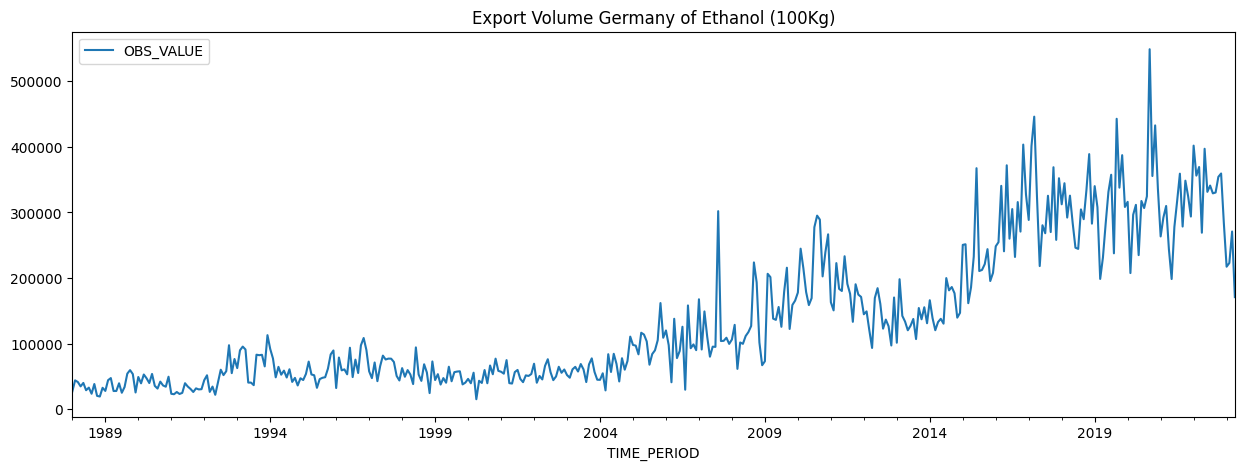

In [5]:
df.plot(style='-', figsize=(15,5), title = "Export Volume Germany of Ethanol (100Kg)")

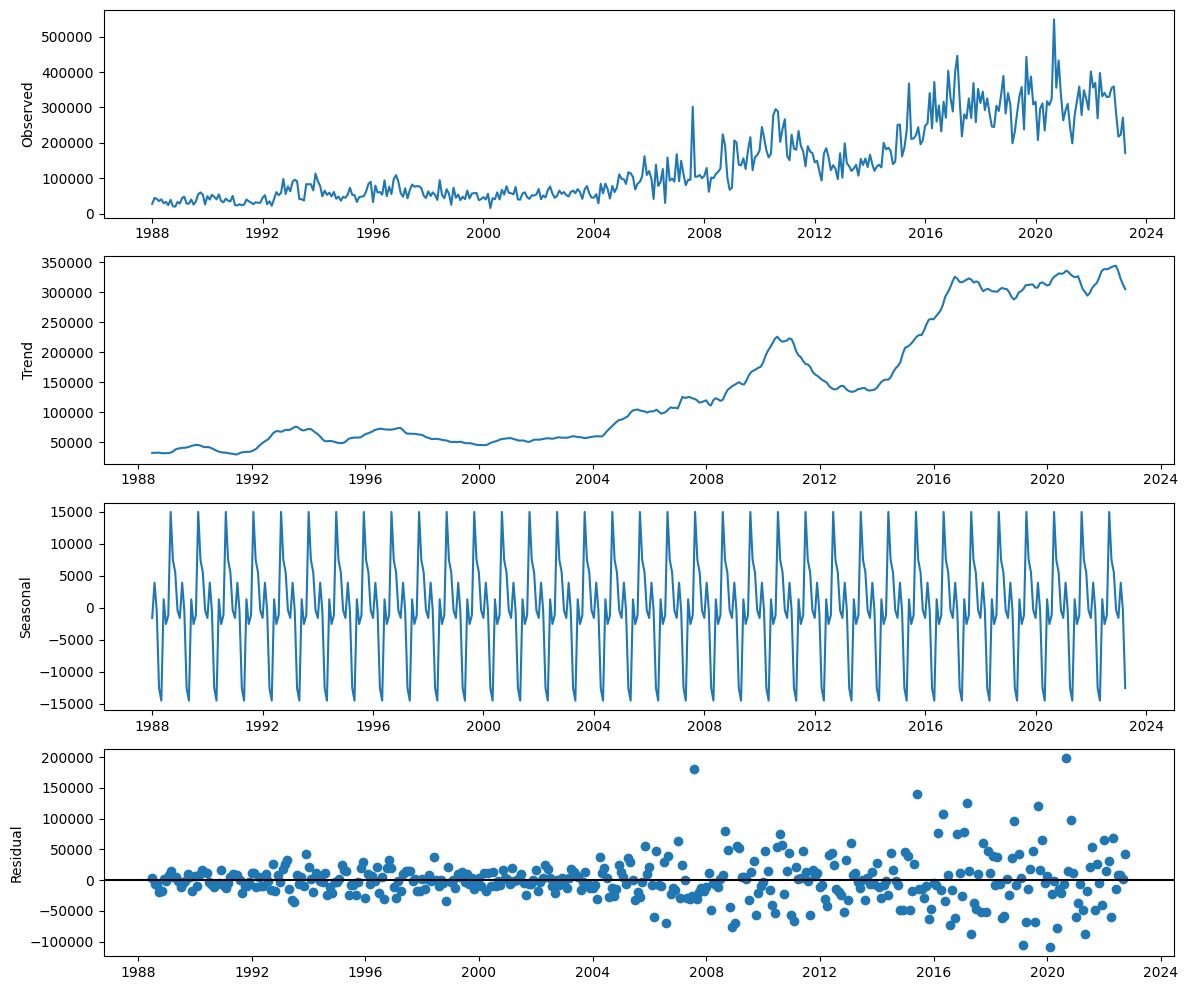

In [209]:
def plot_trend_decomposition(df):
    # Decomposing the time series
    result = seasonal_decompose(df)

    # Getting the figure and axes objects
    fig, axes = plt.subplots(nrows=4, figsize=(12, 10))

    # Plotting the observed, trend, seasonal, and residual components
    axes[0].plot(df.index, df.OBS_VALUE)
    axes[0].set_ylabel('Observed')
    axes[1].plot(result.trend.index, result.trend)
    axes[1].set_ylabel('Trend')
    axes[2].plot(result.seasonal.index, result.seasonal)
    axes[2].set_ylabel('Seasonal')
    axes[3].axhline(0, color='black', linestyle='-') # Adding a horizontal line at y=0
    axes[3].scatter(result.resid.index, result.resid)
    axes[3].set_ylabel('Residual')

    plt.tight_layout()

    plt.show()
    
plot_trend_decomposition(df)

## Interpretations

* Trend:
    * No trends = stationary
    * Linear Trend = no transgformations needed for the application of linear models
    * Non-Linear Trend = apply transformations (log, sqrt, etc.) or use non-linear models/ regression
* Seasonality:
    * If there is seasonality incorporate it in the forecast model
* Residuals:
    * Residuals should be random and close to zero (constant variaton). If not, it indicates a violation of the assumption of constant variance (homoscedasticity) in the time series
    * Aplly Transformations, wieghet least squares, time segmentation, GARCH models
 

In [675]:
def seasonality(df, model = "additive"):
    decompose = seasonal_decompose(df, model = model)
    i = 1
    period = i
    while i < len(decompose.seasonal):
        if round(decompose.seasonal[i], 10) == round(decompose.seasonal[0], 10):
            period = i
            i = len(decompose.seasonal)
        i = i + 1
    
    if period != i:
        return period
    else:
        return "No seasonality"
    
period = seasonality(df, model = "multiplicative")
period

12

## Is the Time Series Stationary?

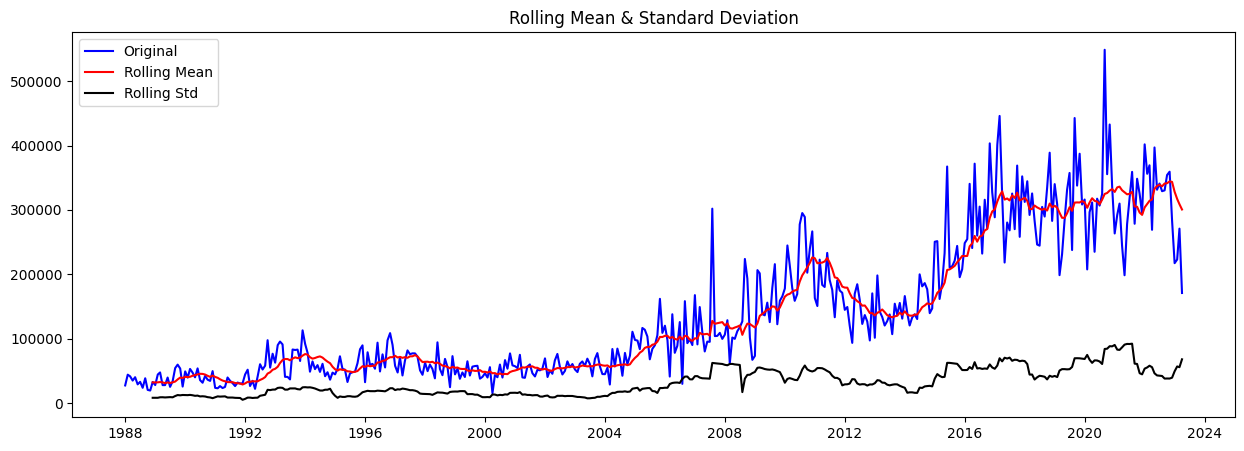

ADF Statistic: -0.6648926446487872
p-value: 0.8556348065725831
Critical Values:
	1%: -3.4462831955497135
	5%: -2.8685636962704395
	10%: -2.5705114078759914


In [211]:
def get_stationarity(timeseries, y = 'OBS_VALUE'):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    fig, ax = plt.subplots(1, figsize=(15,5))
    
    # rolling statistics plot
    original = ax.plot(timeseries, color='blue', label='Original')
    mean = ax.plot(rolling_mean, color='red', label='Rolling Mean')
    std = ax.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries[y])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
               
get_stationarity(df)

not stationarary

### "Stationarizing the data"
Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases. 

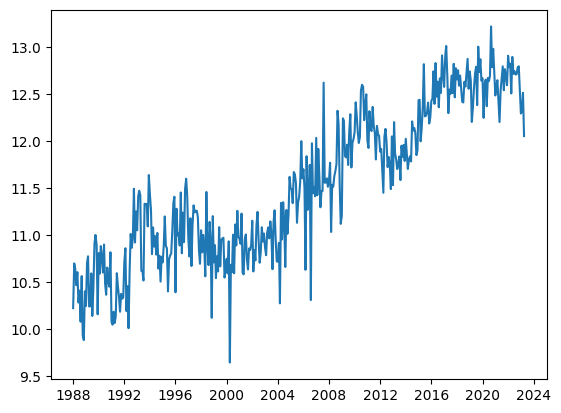

In [6]:
df_log = np.log(df)
plt.plot(df_log)

Then we can test different data ransformatons to "stationarize the data":
1. Subtracting the rolling mean
2. Exponential decay
3. Time shifting

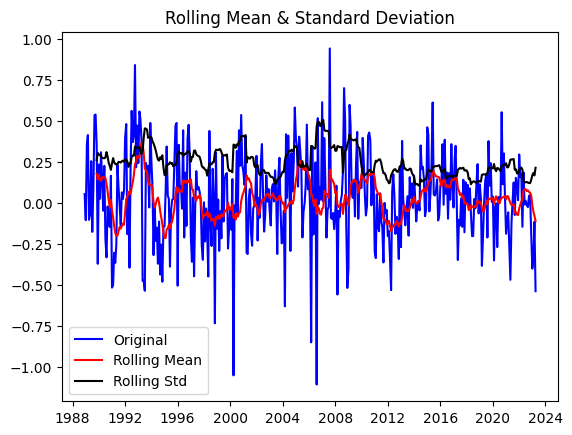

ADF Statistic: -11.306042864515295
p-value: 1.2725965105694529e-20
Critical Values:
	1%: -3.4463612216221775
	5%: -2.8685980017932917
	10%: -2.5705296947685605


In [7]:
# Subtracting the rolling mean
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

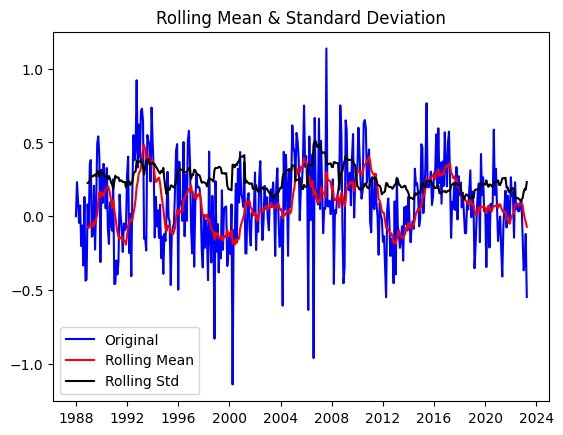

ADF Statistic: -5.0222588978020415
p-value: 2.004873515318841e-05
Critical Values:
	1%: -3.4460914174990296
	5%: -2.868479374038333
	10%: -2.570466459559076


In [8]:
# Exponential decay
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

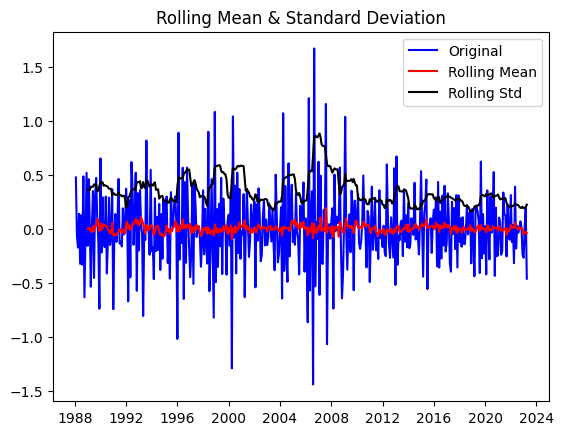

ADF Statistic: -11.991389223953378
p-value: 3.514384105494414e-22
Critical Values:
	1%: -3.4461675720270404
	5%: -2.8685128587855955
	10%: -2.5704843086630915


In [9]:
# Time shift
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

**Time Shift performed the best**

# Train/ Test Split

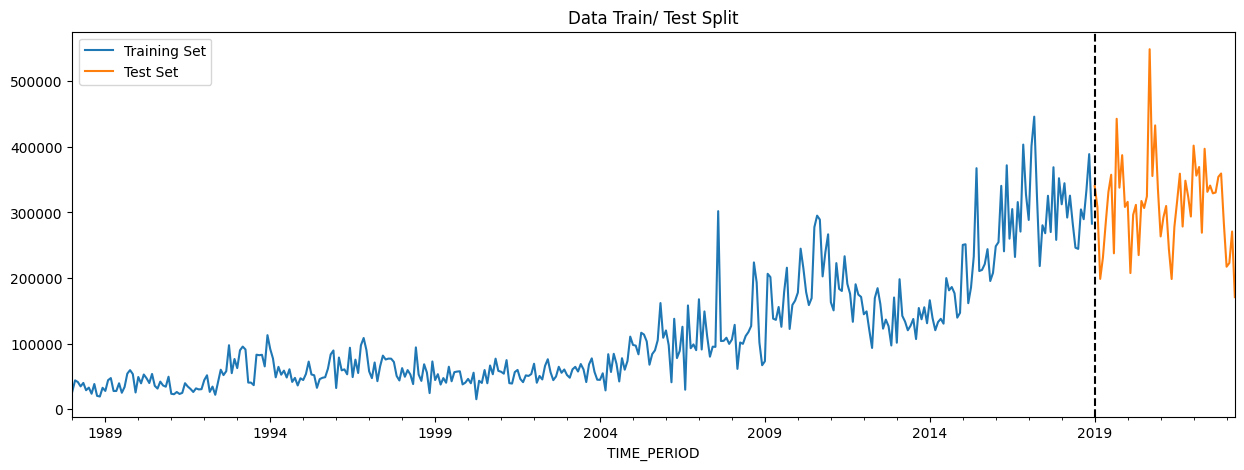

In [485]:
df = df.dropna()
train = df.loc[df.index < '2019-01']
test = df.loc[df.index >= '2019-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2019-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/ Test Split')
plt.show()

In [16]:
test_periods = len(test)
forecast_periods = 12 * 10 # 12 months * 10 years (2033)
periods = test_periods + forecast_periods
periods

172

# ARIMA Model

## Auto ARIMA

In [377]:
auto_arima_model = auto_arima(train,
                            start_p=0,
                            d=None,
                            start_q=0,
                            max_p=20,
                            max_d=20,
                            max_q=20,
                            start_P=0,
                            D=None,
                            start_Q=0,
                            max_P=20,
                            max_D=20,
                            max_Q=20,
                            max_order=20,
                            m=12,
                            seasonal=True,
                            stationary=False,
                            information_criterion='aic',
                            alpha=0.05,
                            error_action='trace',
                            trace=False,
                            random_state=None,
                            n_fits=50)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  372
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -4397.347
Date:                Mon, 31 Jul 2023   AIC                           8808.694
Time:                        19:02:08   BIC                           8836.108
Sample:                    01-01-1988   HQIC                          8819.582
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3376.0100   1381.411      2.444      0.015     668.494    6083.526
ar.L1         -1.4662      0.084    -17.400      0.000      -1.631      -1.301
ar.L2         -0.7095      0.088     -8.031      0.000      -0.883      -0.536
ma.L1          0.7637      0.078      9.796      0.000       0.611       0.916
ma.L2         -0.3826      0.059     -6.474      0.000      -0.498      -0.267
ma.L3         -0.6607      0.052    -12.642      0.000      -0.763      -0.558
sigma2      1.187e+09      0.015   7.84e+10      0.000    1.19e+09    1.19e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               496.57
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               8.30   Skew:                             1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.71e+25. Standard errors may be unstable.
"""

In [378]:
pred, ci = auto_arima_model.predict(periods, return_conf_int=True)
predictions = pd.DataFrame(pred, columns=["predictions"])
conf_int = pd.DataFrame(ci, columns=["lower_ci", "upper_ci"])
predictions.loc[:,"lower_ci"] = conf_int["lower_ci"].values
predictions.loc[:,"upper_ci"] = conf_int["upper_ci"].values
predictions

,predictions,lower_ci,upper_ci
2019-01-01,304523.949707,237002.432087,372045.467327
2019-02-01,317541.491338,247095.290571,387987.692105
2019-03-01,318864.224851,246646.656863,391081.792839
2019-04-01,311065.133450,238001.523869,384128.743031
2019-05-01,324937.597971,248884.778109,400990.417834
...,...,...,...
2032-12-01,491424.825671,281654.832694,701194.818648
2033-01-01,492487.912088,282159.350627,702816.473549
2033-02-01,493550.998504,282665.348022,704436.648986
2033-03-01,494614.084921,283172.813188,706055.356653


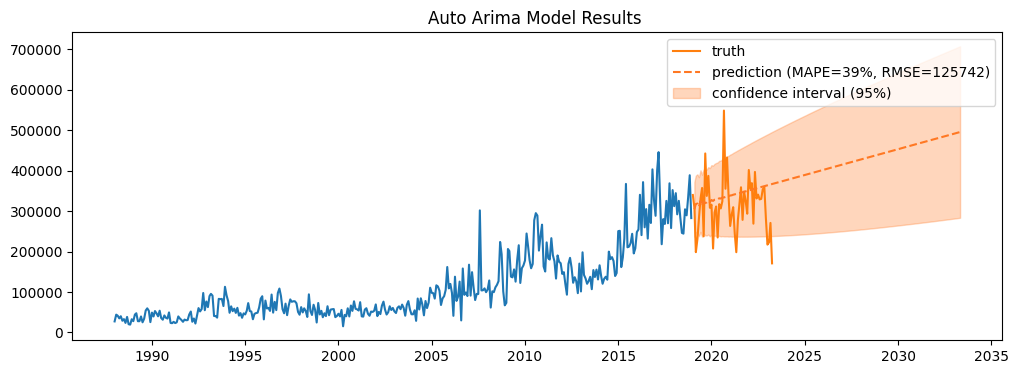

In [487]:

def forecast_results(forecast_df, train_fit = None, title=""):
    start_date = test.index.min()
    end_date = pd.to_datetime('2033-05', format='%Y-%m')

    # Create the new DateTime index until December 2033
    extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

    lower_bounds = forecast_df['lower_ci']
    upper_bounds = forecast_df['upper_ci']
    
    # metrics
    rmse = round(np.sqrt(np.mean(np.square(test.values - forecast_df["predictions"].values))))
    mape = round((np.mean(np.abs(test.values - forecast_df["predictions"].values)/test.values*100)))
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train.OBS_VALUE.index, train.OBS_VALUE.values)
    
    if train_fit:
        ax.plot(train.OBS_VALUE.index, train_fit.values)
        
    ax.plot(test.index, test.values, label='truth')
    ax.plot(extended_index,  forecast_df["predictions"].values, color='#ff7823', linestyle='--', label=f"prediction (MAPE={mape}%, RMSE={rmse})")
    ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
    ax.legend()
    ax.set_title(f"{title} Model Results ")
    
forecast_results(predictions, title="Auto Arima")

## ARIMA

Text(0.5, 1.0, 'Tuned SARIMA Model Results')

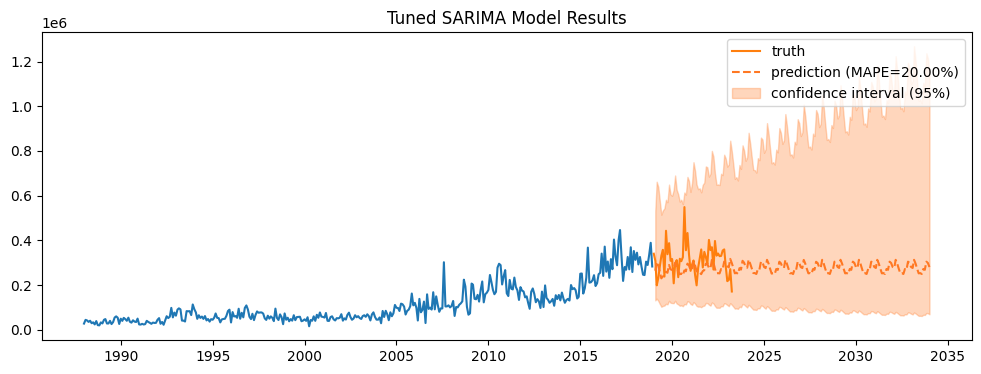

In [563]:
sarima_model = SARIMAX(np.log(train),  seasonal_order=(5, 1, 5, 12), enforce_invertibility=False, enforce_stationarity=False)
#sarima_model = ARIMA(train, order=(1, 1, 3))
sarima_fit = sarima_model.fit()

start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

sarima_pred = sarima_fit.get_prediction("2019-01", "2033-12")
predicted_means = np.exp(sarima_pred.predicted_mean)
predicted_intervals = np.exp(sarima_pred.conf_int(alpha=0.05))
lower_bounds = predicted_intervals['lower OBS_VALUE']
upper_bounds = predicted_intervals['upper OBS_VALUE']

# metrics
rmse = round(np.sqrt(np.mean(np.square(test.values - predicted_means.values))))
mape = round((np.mean(np.abs(test.values - predicted_means.values)/test.values*100)))
sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction("1998-01", "2023-04").predicted_mean.values)/df.values*100))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.OBS_VALUE.index, train.OBS_VALUE.values)
#ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
ax.plot(test.index, test.values, label='truth')
ax.plot(extended_index, predicted_means, color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(mape))
ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("Tuned SARIMA Model Results")

# Volatility Forecasting - Heteroescedascity

If there is non-constant variance (i.e. the timeseries residuals do not follow a uniform distirbution), we can try to forecast the variance, and use it as input for a SARIMAX model

In [634]:
from arch import arch_model

model = arch_model(df.OBS_VALUE, vol="GARCH", p=1, q=1)
results = model.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 15074.106388763415
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5445.86520328216
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5426.024590765239
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5425.77451293514
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5425.740118853456
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5425.740115291522
Iteration:      7,   Func. Count:     41,   Neg. LLF: 5425.740107700354
Iteration:      8,   Func. Count:     46,   Neg. LLF: 5425.740084553346
Iteration:      9,   Func. Count:     51,   Neg. LLF: 5425.740045851904
Iteration:     10,   Func. Count:     56,   Neg. LLF: 5425.73981308144
Iteration:     11,   Func. Count:     61,   Neg. LLF: 5425.739250385796
Iteration:     12,   Func. Count:     66,   Neg. LLF: 5425.738053783219
Iteration:     13,   Func. Count:     71,   Neg. LLF: 5425.7325350885585
Iteration:     14,   Func. Count:     76,   Neg. LLF: 5425.725549

In [635]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              OBS_VALUE   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5266.52
Distribution:                  Normal   AIC:                           10541.0
Method:            Maximum Likelihood   BIC:                           10557.2
                                        No. Observations:                  424
Date:                Tue, Aug 01 2023   Df Residuals:                      423
Time:                        15:55:53   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.5305e+04   2097.855     26.363 3.686e-153 [5.119e+04,5.942e+04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.3296e+08  1.307e+08      1.782  7.478e-02 [-2.329e+07,4.892e+08]
alpha[1]       0.6024      0.105      5.764  8.213e-09      [  0.398,  0.807]
beta[1]        0.3976  9.365e-02      4.246  2.178e-05      [  0.214,  0.581]
=============================================================================

Covariance estimator: robust
"""

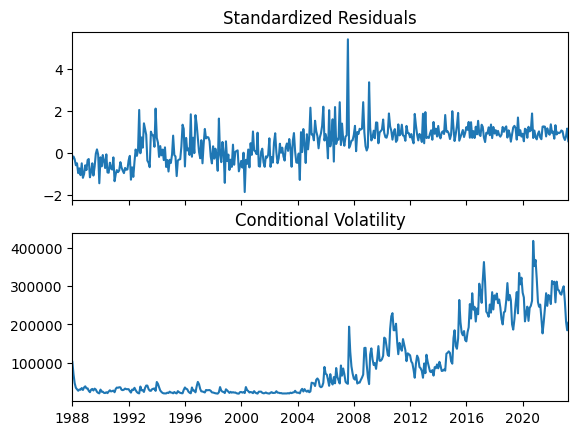

In [636]:
fig = results.plot()
plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6182.564786078043
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4790.981401321877
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4792.816646025048
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4795.5492973846085
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4790.88776222329
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4790.887760790012
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4790.887760789989
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4790.887760790012
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


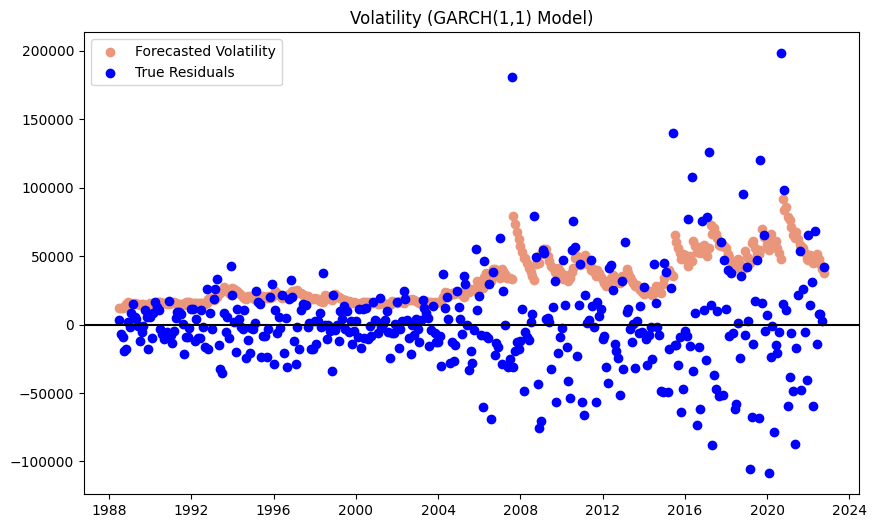

In [686]:
model = arch_model(seasonal_decompose(df).resid.dropna(), vol="GARCH", p=1, q=1)
results = model.fit()
volatility = results._volatility
volatility = volatility
residuals = seasonal_decompose(df).resid.dropna()
# Plot the volatility
plt.figure(figsize=(10, 6))
plt.scatter(seasonal_decompose(df).resid.dropna().index, volatility, label='Forecasted Volatility', color='darksalmon')
plt.axhline(0, color='black', linestyle='-') # Adding a horizontal line at y=0
plt.scatter(seasonal_decompose(df).resid.dropna().index, residuals, label='True Residuals', color = "blue")
plt.title('Volatility (GARCH(1,1) Model)')
plt.legend()
plt.show()

In [707]:
sarima_model = SARIMAX(train,list(volatility[:408]), seasonal_order=(5, 1, 5, 12), enforce_invertibility=False, enforce_stationarity=False)
#sarima_model = ARIMA(train, order=(1, 1, 3))
sarima_fit = sarima_model.fit()

start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

"""
sarima_pred = sarima_fit.get_prediction(test.index.min(), "2033-12"))
predicted_means = sarima_pred.predicted_mean
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower OBS_VALUE']
upper_bounds = predicted_intervals['upper OBS_VALUE']
"""
# metrics
rmse = round(np.sqrt(np.mean(np.square(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max(), exog=list(volatility[len(volatility)-len(test):])).predicted_mean.values))), 2)
mape = round((np.mean(np.abs(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max(), exog=list(volatility[len(volatility)-len(test):])).predicted_mean.values)/test.values*100)), 2)
sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction(df.index.min(), df.index.max(), exog=list(volatility[len(volatility)-len(test):])).predicted_mean.values)/df.values*100))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.index, train.values)
#ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
ax.plot(test.index, test.values, label='truth')
ax.plot(extended_index, predicted_means, color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(mape))
#ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("Tuned SARIMA Model Results - Ethanol Price (€/kg)")

ValueError: endog and exog matrices are different sizes

In [705]:
np.sqrt(results.forecast(horizon = 7).variance).mean(axis=1)

TIME_PERIOD
1988-07-01             NaN
1988-08-01             NaN
1988-09-01             NaN
1988-10-01             NaN
1988-11-01             NaN
                  ...     
2022-06-01             NaN
2022-07-01             NaN
2022-08-01             NaN
2022-09-01             NaN
2022-10-01    39094.787633
Length: 412, dtype: float64

In [695]:
results._volatility[-1]

37381.88780833805

In [685]:
dec.resid.dropna().tail()

TIME_PERIOD
2022-06-01   -13893.532969
2022-07-01     7696.307893
2022-08-01     7676.460274
2022-09-01     2426.488845
2022-10-01    41931.880512
Name: resid, dtype: float64

# Exponential Smoothing

## Setup Hyperparameter Tuning

In [334]:
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    model = ExponentialSmoothing(history, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
    # fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    # make forecast
    yhat = model_fit.forecast(test_periods)
    return yhat


# root mean squared error
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(train, test, cfg):
    
    """ 
    predictions = list()
    # seed history with training dataset
    history = train
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        pd.concat([history, test.iloc[i,:]])
    """
    prediction = exp_smoothing_forecast(train, cfg)
    # estimate prediction error
    error = (np.mean(np.square(test.values - prediction.values)))
    return error
 
# score a model, return None on failure
def score_model(train, test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(train, test, cfg)
    else:
    # one failure during model validation suggests an unstable config
        try: 
            result = walk_forward_validation(train, test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)
 
# grid search configs
def grid_search(train, test, cfg_list, parallel=True, debug = False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(train, test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(train, test, cfg, debug) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

In [348]:

 
# score a model, return None on failure
def score_model(train, test, cfg, debug=False):
    result = None
    rmse = None
    mape = None
    aic = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
            t,d,s,p,b,r = cfg
            # define model model
            model = ExponentialSmoothing(train, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
            # fit model
            model_fit = model.fit(optimized=True, remove_bias=r)
            # make forecast
            pred = model_fit.forecast(test_periods)
            # Calculate metrics
            rmse = np.sqrt(np.mean(np.square(test.values - pred.values)))
            mape = (np.mean(np.abs(test.values -  pred.values)/test.values*100))
            aic = model_fit.aic
    else:
    # one failure during model validation suggests an unstable config
        try: 
            t,d,s,p,b,r = cfg
            # define model model
            model = ExponentialSmoothing(train, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
            # fit model
            model_fit = model.fit(optimized=True, remove_bias=r)
            # make forecast
            pred = model_fit.forecast(test_periods)
            # Calculate metrics
            rmse = np.sqrt(np.mean(np.square(test.values - pred.values)))
            mape = (np.mean(np.abs(test.values - pred.values)/test.values*100))
            aic = model_fit.aic
        except:
            error = None
    return (key, rmse, mape, aic)
 
# grid search configs
def grid_search(train, test, cfg_list, parallel=True, debug = False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(train, test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(train, test, cfg, debug) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[seasonality(df)]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models





In [355]:
warnings.filterwarnings("ignore")
# model configs
cfg_list = exp_smoothing_configs()
# grid search
scores = grid_search(train, test, cfg_list, parallel=False, debug = False)
print('done')
# list top 3 configs
for cfg, rmse, mape, aic in scores[:3]:
    print(cfg,  rmse, mape, aic)

done
[None, False, None, 12, False, False] 67489.09763457967 17.402143151811206 7781.390663655013
[None, False, None, 12, True, True] 67493.9220197003 17.53183828563924 7793.173165112848
[None, False, None, 12, False, True] 67494.79284752392 17.533399475452647 7781.390663655013


Text(0.5, 1.0, 'Sesonal Exponential Smoothing Model w/ Growth Results ')

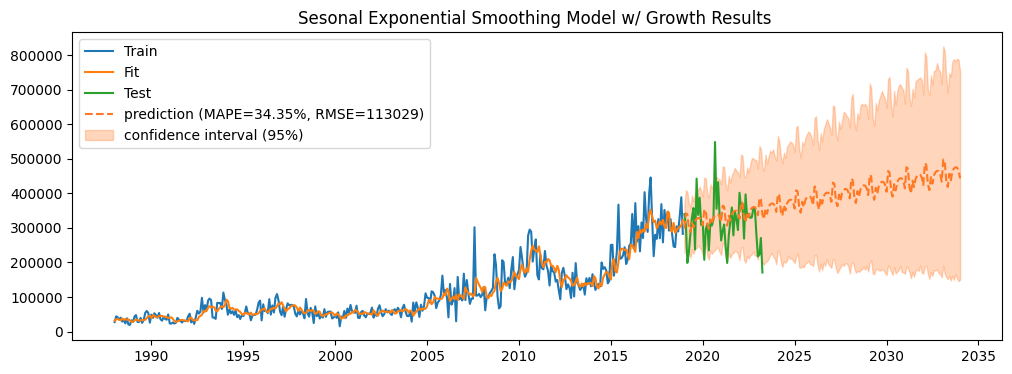

In [529]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

train_x = train[train.index >= pd.to_datetime("1988")].copy()

# Build model.
ets_model = ETSModel(
    endog=train_x.OBS_VALUE, # should be a pd.Series
    trend="add",
    damped_trend=False,
    seasonal="mul",
    seasonal_periods=12
)
fit = ets_model.fit()


start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

pred = fit.get_prediction(start=test.index[0], end=extended_index[-1]).summary_frame(alpha=0.05)
pred = pred.rename(columns={"mean":"prediction"})

# Calculate metrics
rmse = np.sqrt(np.mean(np.square(test.values - pred.prediction.values)))
mape = (np.mean(np.abs(test.values -  pred.prediction.values)/test.values*100))
aic = fit.aic


fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_x.OBS_VALUE.index, train_x.OBS_VALUE.values, label = "Train")
ax.plot(train_x.OBS_VALUE.index, fit.fittedvalues, label = "Fit")

ax.plot(test.index, test.values, label='Test')
ax.plot(pred.index,  pred.prediction.values, color='#ff7823', linestyle='--', label=f"prediction (MAPE={round(mape,2)}%, RMSE={round(rmse)})")
ax.fill_between(pred.index, pred.pi_lower.values, pred.pi_upper.values, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title(f"Sesonal Exponential Smoothing Model w/ Growth Results ")

Text(0.5, 1.0, 'Cross Validation Exponential Smoothing Model Results ')

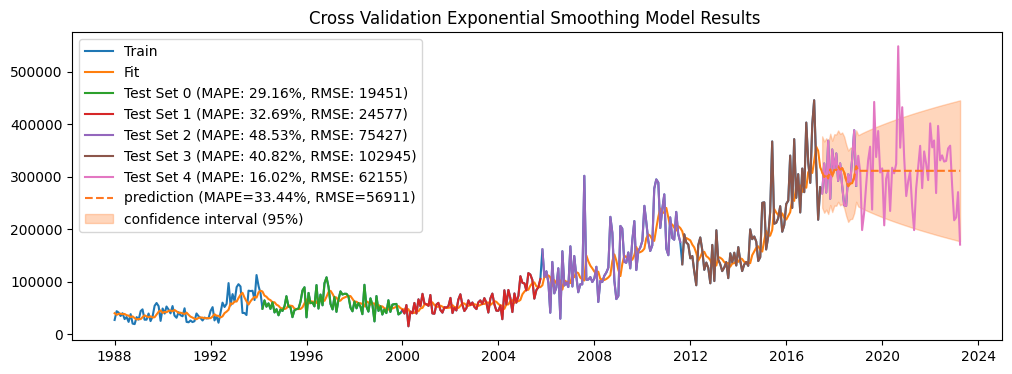

In [466]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 5)
rmses = []
mapes = []
aics = []
test_sets = []
train_sets = []
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    train_sets.append(cv_train)
    test_sets.append(cv_test)
    # Build model.
    ets_model = ETSModel(
        endog=train.OBS_VALUE, # should be a pd.Series
        #trend="add",
        #damped_trend=True,
        #seasonal="mul",
        #seasonal_periods=12
    )
    fit = ets_model.fit()
    pred = fit.get_prediction(start = cv_test.index.values[0], end = cv_test.index.values[-1]).summary_frame(alpha=0.05)
    pred = pred.rename(columns={"mean":"prediction"})
    true_values = cv_test.values

    # Calculate metrics
    rmse = np.sqrt(np.mean(np.square(cv_test.values - pred.prediction.values)))
    mape = (np.mean(np.abs(cv_test.values -  pred.prediction.values)/cv_test.values*100))
    aic = fit.aic
    rmses.append(rmse)
    mapes.append(mape)
    aics.append(aic)

rmse = np.mean(rmses)
mape = np.mean(mapes)
aic = np.mean(aics)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.OBS_VALUE.index, train.OBS_VALUE.values, label = "Train")
ax.plot(train.OBS_VALUE.index, fit.fittedvalues, label = "Fit")
for i in range(len(test_sets)):
    ax.plot(test_sets[i].index, test_sets[i].values, label=f'Test Set {i} (MAPE: {round(mapes[i],2)}%, RMSE: {round(rmses[i])})')
ax.plot(pred.index,  pred.prediction.values, color='#ff7823', linestyle='--', label=f"prediction (MAPE={round(mape,2)}%, RMSE={round(rmse)})")
ax.fill_between(pred.index, pred.pi_lower.values, pred.pi_upper.values, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title(f"Cross Validation Exponential Smoothing Model Results ")

In [465]:
train_sets[4]

,OBS_VALUE
TIME_PERIOD,
1988-01-01,27411
1988-02-01,44108
1988-03-01,41559
1988-04-01,34977
1988-05-01,40197
...,...
2017-02-01,401068
2017-03-01,445912
2017-04-01,324036


In [455]:
mapes

[30.254356293412773,
 33.81075449411049,
 49.754094726822416,
 42.441259460804865,
 16.505564727706183]

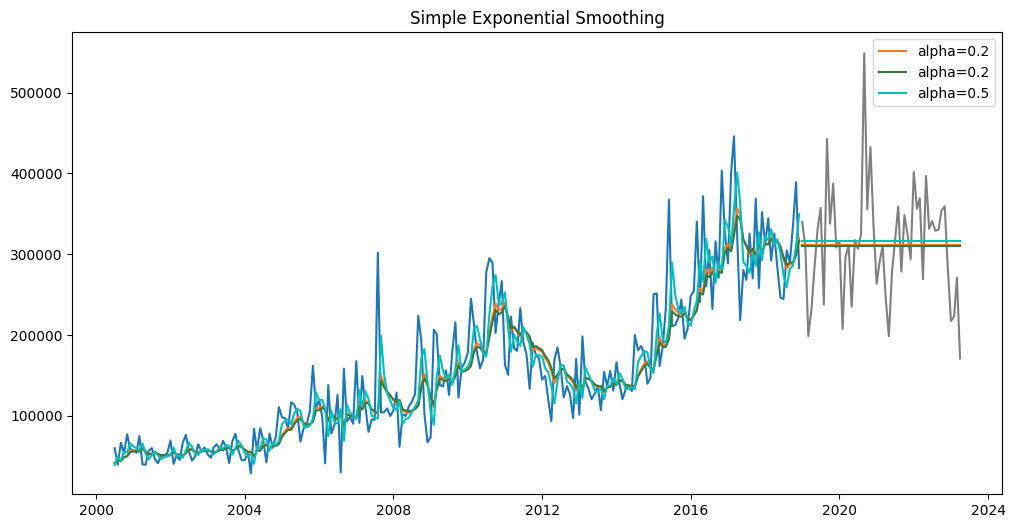

In [389]:
train.index = pd.to_datetime(train.index)
model = SimpleExpSmoothing(np.asarray(train['OBS_VALUE']), )

fit1 = model.fit()
pred1 = fit1.forecast(test_periods)
fit2 = model.fit(smoothing_level=.2, optimized=False)
pred2 = fit2.forecast(test_periods)
fit3 = model.fit(smoothing_level=.5, optimized=False)
pred3 = fit3.forecast(test_periods)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend()
    

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


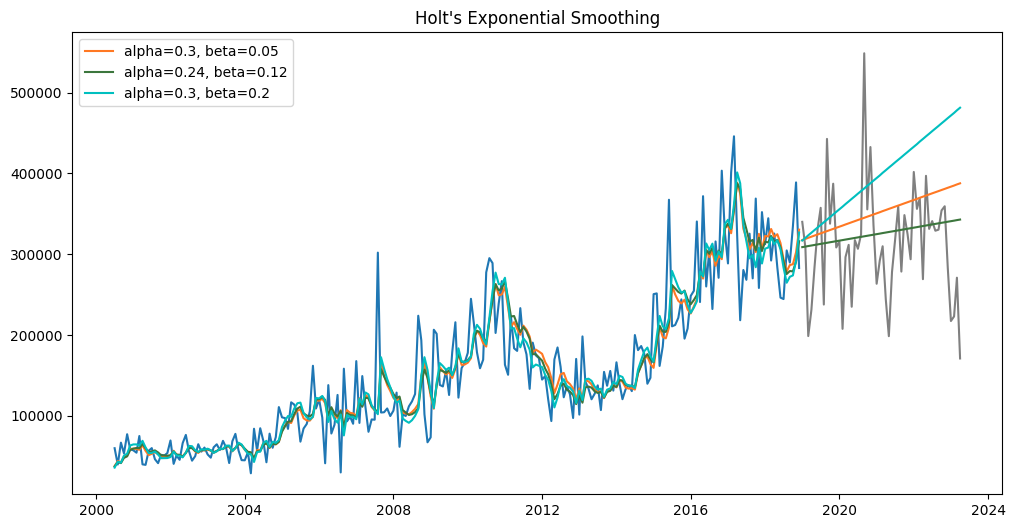

In [37]:
train.index = pd.to_datetime(train.index)
model = Holt(np.asarray(train['OBS_VALUE']))

fit1 = model.fit(smoothing_level=.3, smoothing_trend=.05, optimized=False)
pred1 = fit1.forecast(test_periods)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(test_periods)
fit3 = model.fit(smoothing_level=.3, smoothing_trend=.2, optimized=False)
pred3 = fit3.forecast(test_periods)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend()

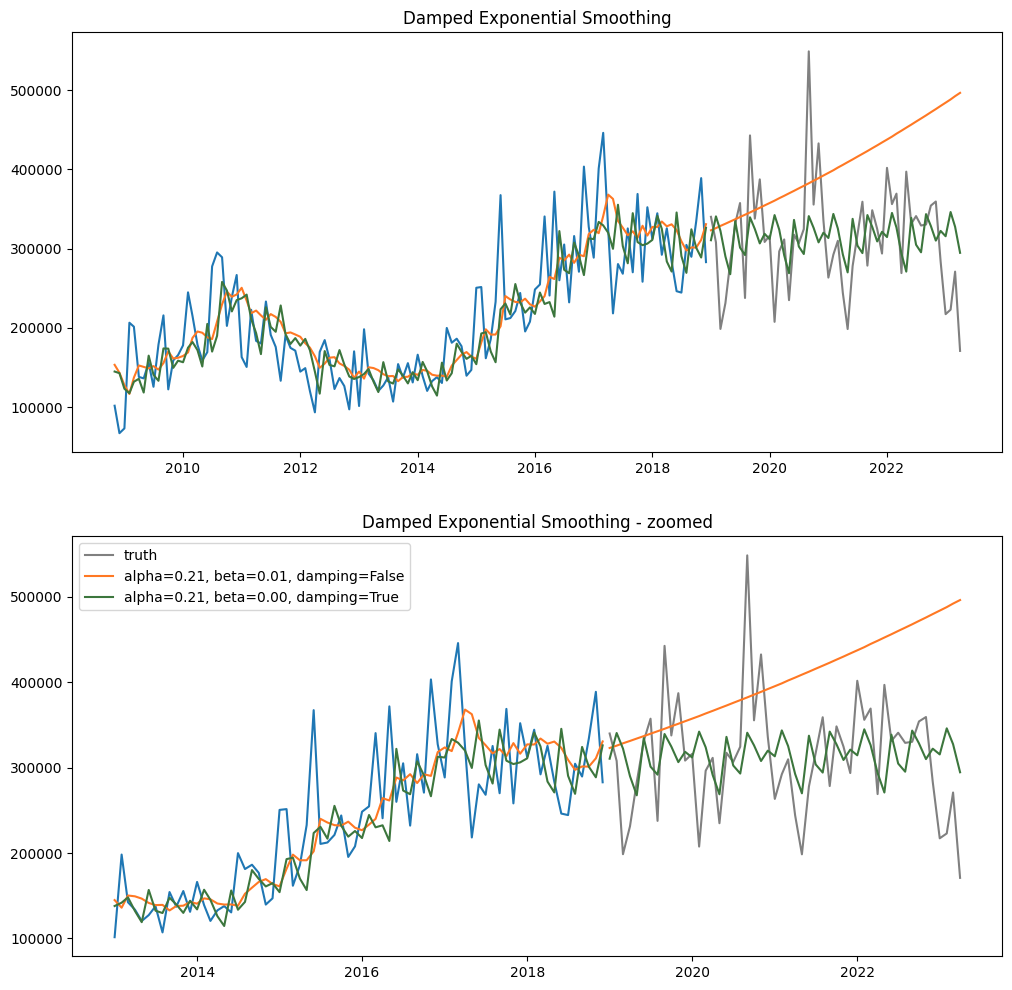

In [442]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(np.asarray(train['OBS_VALUE']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['OBS_VALUE']), trend='mul', seasonal="mul", seasonal_periods=12, damped_trend=True)

fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(test_periods)
pred2 = fit2.forecast(test_periods)

fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index[250:], train.values[250:])
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index[300:], train.values[300:])
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index[250:], f.fittedvalues[250:], color=c)
    ax[1].plot(train.index[300:], f.fittedvalues[300:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


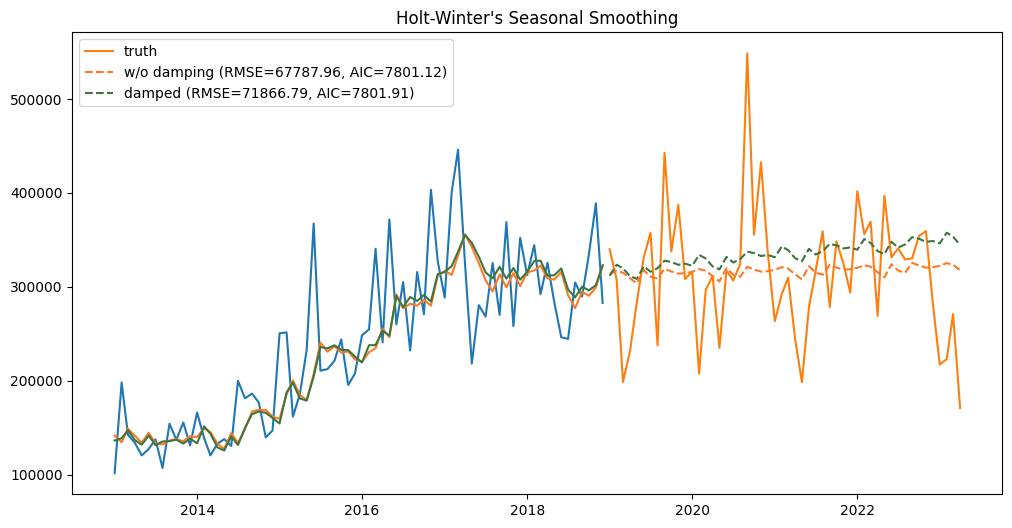

In [65]:
c

# ARIMA model

In [135]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train, order=(1, 1, 3), seasonal_order=(1, 1, 3, 12), enforce_invertibility=False, enforce_stationarity=False)
#sarima_model = ARIMA(train, order=(1, 1, 3))
sarima_fit = sarima_model.fit()


C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


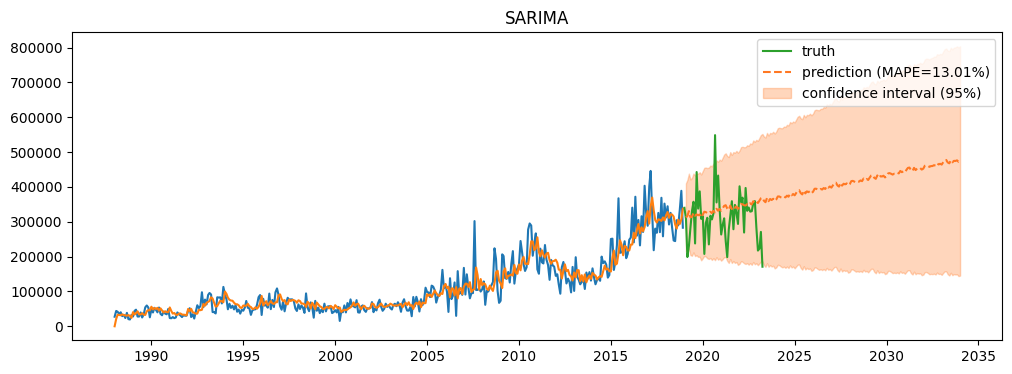

In [138]:

start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

sarima_pred = sarima_fit.get_prediction("2019-01", "2033-12")
predicted_means = sarima_pred.predicted_mean
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower OBS_VALUE']
upper_bounds = predicted_intervals['upper OBS_VALUE']

sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction("1998-01", "2023-04").predicted_mean.values)/df.values*100))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.OBS_VALUE.index, train.OBS_VALUE.values)
ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
ax.plot(test.index, test.values, label='truth')
ax.plot(extended_index, predicted_means, color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(sarima_rmse))
ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("SARIMA")

In [125]:
extended_index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31',
               ...
               '2033-02-28', '2033-03-31', '2033-04-30', '2033-05-31',
               '2033-06-30', '2033-07-31', '2033-08-31', '2033-09-30',
               '2033-10-31', '2033-11-30'],
              dtype='datetime64[ns]', length=179, freq='M')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.OBS_VALUE.index, train.OBS_VALUE.values);
ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test.index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");

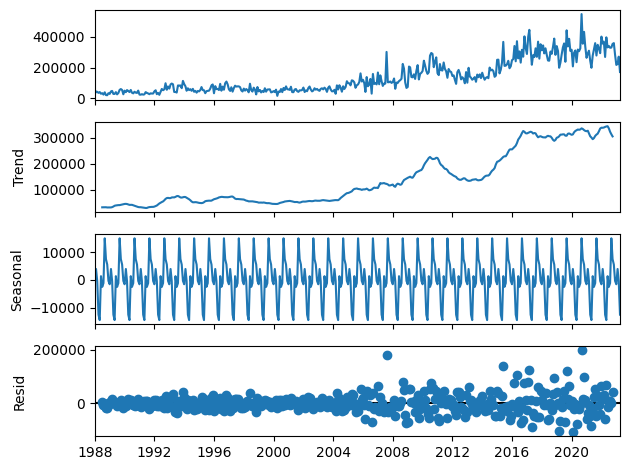

In [147]:
seasonal_decompose(df).plot()
plt.show()

In [13]:
# Draw ACF and PACF plots

sm.graphics.tsa.plot_acf(df_log_shift['OBS_VALUE'], lags = 15) # Select AR order
sm.graphics.tsa.plot_pacf(df_log_shift['OBS_VALUE'], lags = 15) # Select MA order
plt.xticks()
plt.show()

NameError: name 'df_log_shift' is not defined

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit()
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 30),
                   d= range(0, 30),
                   q =range(0, 30),
                   trend = ['n', 'c', 't', 'ct']
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = list(df_log_shift['OBS_VALUE'])
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/200 [00:00<?, ?it/s]

best parameters: {'d': 0, 'p': 24, 'q': 29, 'trend': 'n'}
best loss: 0.07469131130693471


In [26]:
def plot_arima(data_values, order = (1,1,1), trend = 'c'):
    print('final model:', order, trend)
    model = ARIMA(data_values, order=order, trend = trend)
    results = model.fit()
    
    error = mean_squared_error(data_values, results.fittedvalues)   
    print('MSE error is:', error)
    
    from matplotlib import pyplot as plt
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(6)
    plt.plot(data_values, label = "original Series", linewidth = 4)
    plt.plot(results.fittedvalues, color='red', label = "Predictions", linestyle='dashed', linewidth = 3)
    plt.legend(fontsize = 25)
    plt.xlabel('Months', fontsize = 25)
    plt.ylabel('Count', fontsize = 25)
    plt.show()

print(results['best_params'])

order = (results['best_params']['p'], results['best_params']['d'], results['best_params']['q'])
plot_arima(data_values, order=order, trend = results['best_params']['trend'])

TypeError: 'ARIMAResultsWrapper' object is not subscriptable

2023-05-01    255768.160520
2023-06-01    255596.414568
2023-07-01    268292.209685
2023-08-01    268292.209685
2023-09-01    268292.209685
                  ...      
2035-06-01    268292.209685
2035-07-01    268292.209685
2035-08-01    268292.209685
2035-09-01    268292.209685
2035-10-01    268292.209685
Freq: MS, Name: predicted_mean, Length: 150, dtype: float64

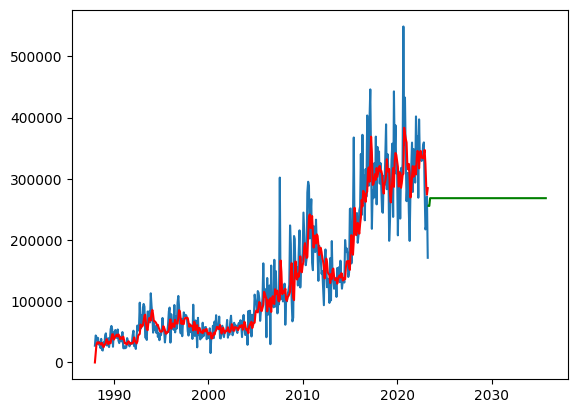

In [49]:
model = ARIMA(df, order=(0,1,3)) 
results = model.fit()
plt.plot(df)
plt.plot(results.fittedvalues, color='red')

forecast = results.forecast(150)
forecast
plt.plot(forecast, color='green')


Text(0.5, 1.0, 'ARIMA Results vs. Real Volume')

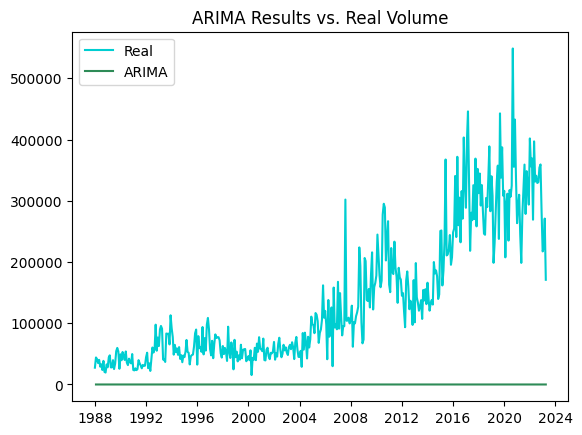

In [44]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['OBS_VALUE'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df, label = "Real", color = "darkturquoise")
plt.plot(results.fittedvalues, label = "ARIMA", color = "seagreen")
plt.legend(loc='best')
plt.title('ARIMA Results vs. Real Volume')

* mean average percentage errror
* LSTM

<Axes: >

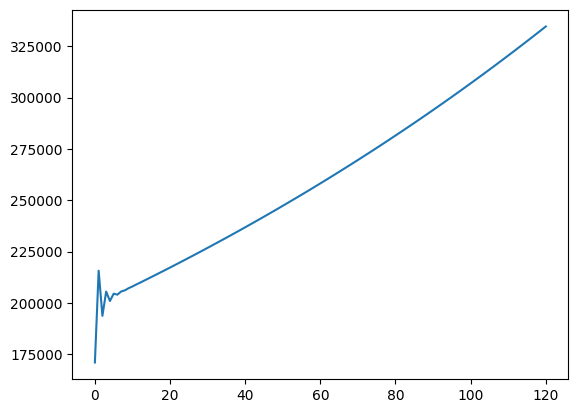

In [210]:
# Number of steps to forecast
n_steps = 120

# Forecast
forecast = results.forecast(steps=n_steps)

# Reverse the differencing
forecast_reversed = np.r_[df_log.iloc[-1], forecast].cumsum()

# Reverse the log transformation
forecast_reversed = np.exp(forecast_reversed)
pd.Series(forecast_reversed).plot()

In [217]:
#df = df.drop('forcast_SARIMA_1', axis = 1)
df.tail()

,OBS_VALUE
TIME_PERIOD,
2022-12-01,283449.36
2023-01-01,217277.89
2023-02-01,222961.62
2023-03-01,270905.33
2023-04-01,170948.46


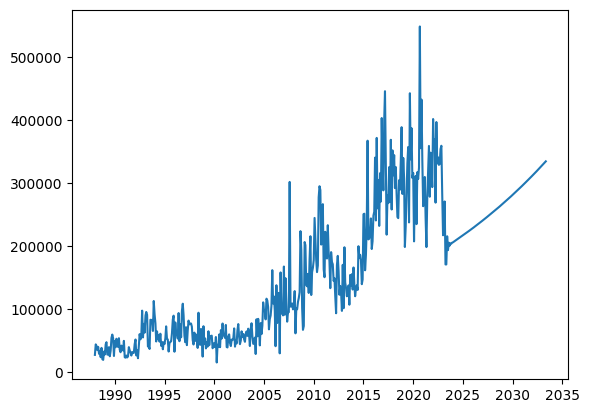

In [225]:
start = datetime.datetime.strptime("2023-05-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,121)]
future = pd.DataFrame(forecast_reversed, index=date_list, columns= df.columns)
future_prediction = pd.concat([df, future])
plt.plot(future_prediction)

In [33]:
stepwise_model = auto_arima(df, start_p=0, start_q=0,
                           max_p=0, max_q=3, m=12,
                           start_P=0, seasonal=True, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=10336.301, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10338.682, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=10336.921, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10184.155, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10336.704, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=10182.689, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=10184.262, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=10185.752, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=10182.864, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=10181.458, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=10182.897, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=10182.866, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=10184.765, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=10180.645, Time=0.06 sec
 ARIM

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

Text(0.5, 1.0, 'ARIMA Results vs. Real Volume')

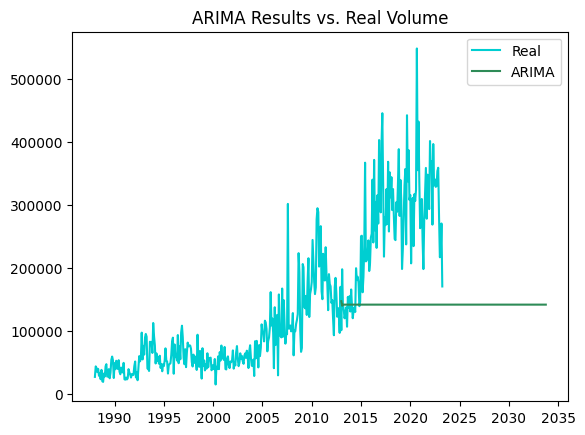

In [41]:
results = stepwise_model.fit_predict(df[:300], n_periods = 250)


plt.plot(df, label = "Real", color = "darkturquoise")
plt.plot(results, label = "ARIMA", color = "seagreen")
plt.legend(loc='best')
plt.title('ARIMA Results vs. Real Volume')




In [179]:
predictions_ARIMA_log = pd.Series(df_log['OBS_VALUE'].iloc[0], index=df_log.index)
predictions_ARIMA_log

TIME_PERIOD
1988-01-01    10.2187
1988-02-01    10.2187
1988-03-01    10.2187
1988-04-01    10.2187
1988-05-01    10.2187
               ...   
2022-12-01    10.2187
2023-01-01    10.2187
2023-02-01    10.2187
2023-03-01    10.2187
2023-04-01    10.2187
Length: 424, dtype: float64

In [180]:
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log

TIME_PERIOD
1988-01-01    10.218700
1988-02-01    10.218700
1988-03-01    10.694396
1988-04-01    11.033782
1988-05-01    11.209997
                ...    
2022-12-01    13.267439
2023-01-01    13.391848
2023-02-01    13.529402
2023-03-01    13.523579
2023-04-01    13.435341
Length: 424, dtype: float64

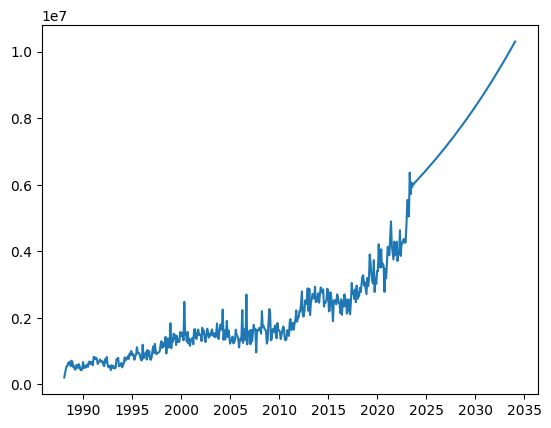

In [186]:
plt.plot(np.exp(pd.Series(results.predict(start=0, end=552)).cumsum() + predictions_ARIMA_log.mean()))

In [176]:
predictions_ARIMA_diff
np.exp(predictions_ARIMA_diff_cumsum)


TIME_PERIOD
1988-02-01     1.000000
1988-03-01     1.609135
1988-04-01     2.259363
1988-05-01     2.694729
1988-06-01     2.727975
                ...    
2022-12-01    21.088743
2023-01-01    23.882568
2023-02-01    27.404356
2023-03-01    27.245266
2023-04-01    24.944202
Length: 423, dtype: float64

In [204]:
model = sm.tsa.statespace.SARIMAX(df.dropna()['OBS_VALUE'],order=(2,1,2),seasonal_order=(2,1,2,6))
result=model.fit()

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LinAlgError: Schur decomposition solver error.

<Axes: xlabel='TIME_PERIOD'>

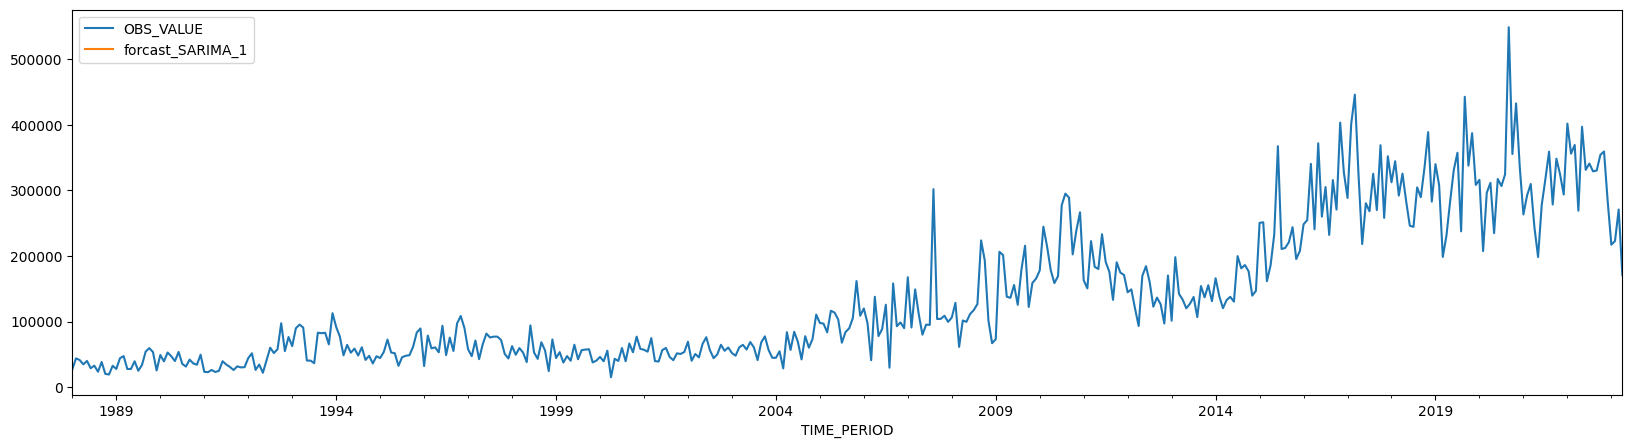

In [199]:
df['forcast_SARIMA_1']=result.predict(start=350, end=552)
df[['OBS_VALUE','forcast_SARIMA_1']].plot(figsize=(20, 5))

In [200]:
import datetime
from dateutil.relativedelta import relativedelta
start = datetime.datetime.strptime("2023-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,120)]
future_prediction = pd.DataFrame(index=date_list, columns= df.columns)
data = pd.concat([df, future_prediction])

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


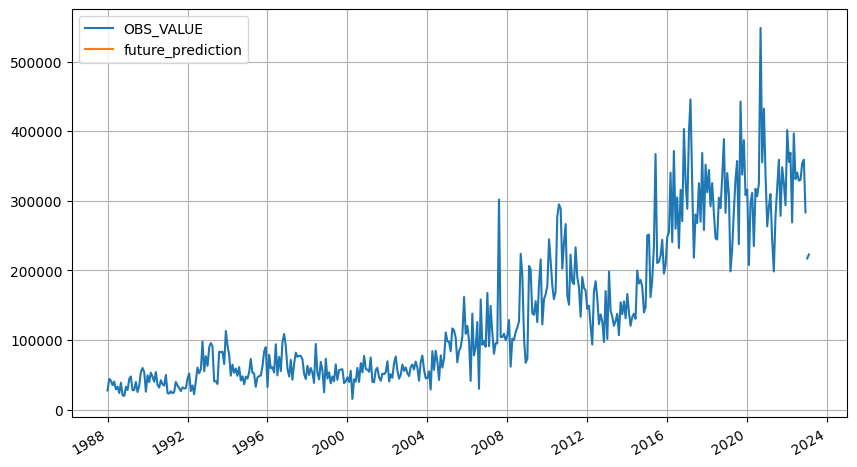

In [201]:
data['future_prediction']=result.predict(start=430, end=552, dynamic=True)
data[['OBS_VALUE','future_prediction']].plot(figsize=(10, 6))
plt.grid(True)

# LSTM Models

Data nees to be in input matrix:
* rows: inputs
* column: label

For every X months, we'll predict the following Y months

In [ ]:
# Example Matrix (3D tensor)

<Axes: xlabel='TIME_PERIOD'>

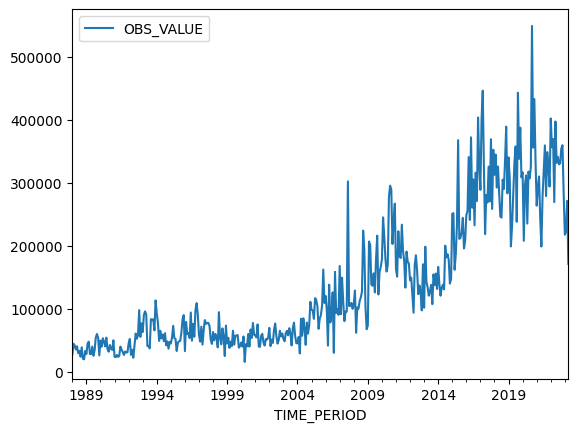

In [784]:
df.plot()

<Axes: xlabel='TIME_PERIOD'>

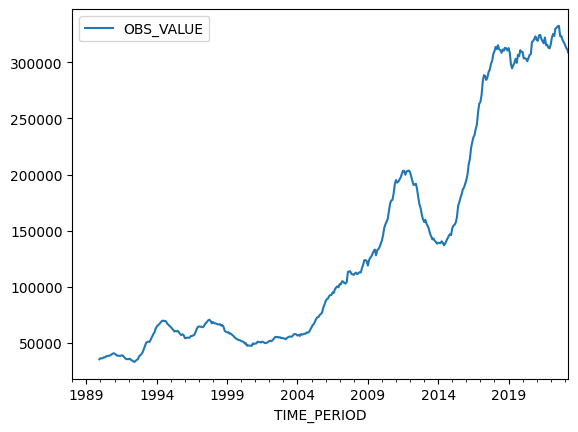

In [882]:
df.rolling(window=24).mean().plot()

In [65]:
df.shape

(424, 1)

In [82]:
def df_to_X_y(df, window_size = 24):
    df_as_np = df#.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [a for a in df_as_np[i: i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)


In [83]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

window_size = 48 
X, y = df_to_X_y(scaler.fit_transform(df.rolling(window=24).mean().dropna()), window_size= window_size)
X.shape, y.shape

((353, 48, 1), (353, 1))

In [84]:
period_test = 50
X_train, y_train = X[:-2*period_test], y[:-2*period_test]
X_val, y_val = X[-2*period_test:-period_test], y[-2*period_test:-period_test]
X_test, y_test = X[-period_test:], y[-period_test:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((253, 48, 1), (253, 1), (50, 48, 1), (50, 1), (50, 48, 1), (50, 1))

In [85]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam


model1 = Sequential()
model1.add(InputLayer((window_size, 1)))
model1.add(LSTM(64, input_shape=(window_size, 1)))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=MeanAbsolutePercentageError())


In [87]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,callbacks=[cp]
          )

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 0.0404 - mean_absolute_percentage_error: 82.6134 INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 4s 341ms/step - loss: 0.0465 - mean_absolute_percentage_error: 80.8561 - val_loss: 0.3806 - val_mean_absolute_percentage_error: 81.6366
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 0.0412 - mean_absolute_percentage_error: 70.2515INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 298ms/step - loss: 0.0385 - mean_absolute_percentage_error: 67.6843 - val_loss: 0.3253 - val_mean_absolute_percentage_error: 75.3911
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 0.0308 - mean_absolute_percentage_error: 55.9285INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 294ms/step - loss: 0.0306 - mean_absolute_percentage_error: 54.4432 - val_loss: 0.2718 - val_mean_absolute_percentage_error: 68.8269
Epoch 4/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0278 - mean_absolute_percentage_error: 43.3941INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 292ms/step - loss: 0.0238 - mean_absolute_percentage_error: 40.7224 - val_loss: 0.2189 - val_mean_absolute_percentage_error: 61.6669
Epoch 5/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 31.9646INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 290ms/step - loss: 0.0169 - mean_absolute_percentage_error: 31.4331 - val_loss: 0.1700 - val_mean_absolute_percentage_error: 54.2188
Epoch 6/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0121 - mean_absolute_percentage_error: 28.2250INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 291ms/step - loss: 0.0115 - mean_absolute_percentage_error: 28.1855 - val_loss: 0.1230 - val_mean_absolute_percentage_error: 45.9565
Epoch 7/50
5/8 [=================>............] - ETA: 0s - loss: 0.0069 - mean_absolute_percentage_error: 30.4180INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 3s 385ms/step - loss: 0.0071 - mean_absolute_percentage_error: 30.4192 - val_loss: 0.0818 - val_mean_absolute_percentage_error: 37.2867
Epoch 8/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0049 - mean_absolute_percentage_error: 33.5373INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 290ms/step - loss: 0.0045 - mean_absolute_percentage_error: 35.9816 - val_loss: 0.0483 - val_mean_absolute_percentage_error: 28.3597
Epoch 9/50
5/8 [=================>............] - ETA: 0s - loss: 0.0036 - mean_absolute_percentage_error: 39.7796INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 292ms/step - loss: 0.0033 - mean_absolute_percentage_error: 41.4834 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 21.4628
Epoch 10/50
5/8 [=================>............] - ETA: 0s - loss: 0.0032 - mean_absolute_percentage_error: 45.0163INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 291ms/step - loss: 0.0030 - mean_absolute_percentage_error: 43.2138 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 18.6597
Epoch 11/50
5/8 [=================>............] - ETA: 0s - loss: 0.0029 - mean_absolute_percentage_error: 39.2465INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 301ms/step - loss: 0.0027 - mean_absolute_percentage_error: 40.1438 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 18.7384
Epoch 12/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0024 - mean_absolute_percentage_error: 35.6744 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 19.8378
Epoch 13/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0023 - mean_absolute_percentage_error: 32.4650 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 19.3511
Epoch 14/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0020 - mean_absolute_percentage_error: 28.9393INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 288ms/step - loss: 0.0022 - mean_absolute_percentage_error: 31.1164 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 18.2480
Epoch 15/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0020 - mean_absolute_percentage_error: 31.0803INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 293ms/step - loss: 0.0021 - mean_absolute_percentage_error: 30.2709 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 16.9097
Epoch 16/50
5/8 [=================>............] - ETA: 0s - loss: 0.0019 - mean_absolute_percentage_error: 30.2829INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 302ms/step - loss: 0.0020 - mean_absolute_percentage_error: 29.5083 - val_loss: 0.0160 - val_mean_absolute_percentage_error: 16.1851
Epoch 17/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0020 - mean_absolute_percentage_error: 27.9790INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 3s 394ms/step - loss: 0.0019 - mean_absolute_percentage_error: 28.2455 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 15.9745
Epoch 18/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0018 - mean_absolute_percentage_error: 26.5622 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 16.4099
Epoch 19/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0018 - mean_absolute_percentage_error: 26.8686INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 287ms/step - loss: 0.0018 - mean_absolute_percentage_error: 25.3708 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 15.9721
Epoch 20/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0017 - mean_absolute_percentage_error: 23.7162INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 291ms/step - loss: 0.0017 - mean_absolute_percentage_error: 24.3605 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 15.6203
Epoch 21/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0016 - mean_absolute_percentage_error: 23.0915INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 297ms/step - loss: 0.0017 - mean_absolute_percentage_error: 23.9094 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 14.8514
Epoch 22/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0017 - mean_absolute_percentage_error: 23.1596 - val_loss: 0.0138 - val_mean_absolute_percentage_error: 15.0371
Epoch 23/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0015 - mean_absolute_percentage_error: 22.8133INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 295ms/step - loss: 0.0016 - mean_absolute_percentage_error: 22.4394 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 14.5536
Epoch 24/50
5/8 [=================>............] - ETA: 0s - loss: 0.0017 - mean_absolute_percentage_error: 22.0637INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 302ms/step - loss: 0.0016 - mean_absolute_percentage_error: 22.2794 - val_loss: 0.0123 - val_mean_absolute_percentage_error: 14.0739
Epoch 25/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0016 - mean_absolute_percentage_error: 21.6839 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 14.2056
Epoch 26/50
5/8 [=================>............] - ETA: 0s - loss: 0.0016 - mean_absolute_percentage_error: 20.1395INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 295ms/step - loss: 0.0015 - mean_absolute_percentage_error: 21.0993 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 14.0508
Epoch 27/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0015 - mean_absolute_percentage_error: 20.5650 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 14.3087
Epoch 28/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0015 - mean_absolute_percentage_error: 20.1670INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 287ms/step - loss: 0.0015 - mean_absolute_percentage_error: 20.5103 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 13.6425
Epoch 29/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0015 - mean_absolute_percentage_error: 20.3553 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 13.8213
Epoch 30/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0015 - mean_absolute_percentage_error: 21.0842INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 3s 401ms/step - loss: 0.0015 - mean_absolute_percentage_error: 20.0485 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 13.0459
Epoch 31/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0014 - mean_absolute_percentage_error: 19.9831 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 13.3360
Epoch 32/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0014 - mean_absolute_percentage_error: 19.2238 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 13.7539
Epoch 33/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0015 - mean_absolute_percentage_error: 20.0219INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 290ms/step - loss: 0.0014 - mean_absolute_percentage_error: 19.2027 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 13.1470
Epoch 34/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0014 - mean_absolute_percentage_error: 18.9155 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 13.5826
Epoch 35/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0014 - mean_absolute_percentage_error: 19.5105INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 290ms/step - loss: 0.0013 - mean_absolute_percentage_error: 18.8229 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 13.0288
Epoch 36/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0013 - mean_absolute_percentage_error: 18.7445 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 13.1412
Epoch 37/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0014 - mean_absolute_percentage_error: 18.5543INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 289ms/step - loss: 0.0013 - mean_absolute_percentage_error: 18.4238 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 12.7539
Epoch 38/50
5/8 [=================>............] - ETA: 0s - loss: 0.0013 - mean_absolute_percentage_error: 18.6379INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 289ms/step - loss: 0.0013 - mean_absolute_percentage_error: 18.6106 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 12.6974
Epoch 39/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0013 - mean_absolute_percentage_error: 18.0558 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 13.0036
Epoch 40/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_absolute_percentage_error: 17.6364INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 289ms/step - loss: 0.0012 - mean_absolute_percentage_error: 17.9288 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 12.5526
Epoch 41/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_absolute_percentage_error: 17.7446 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 12.8463
Epoch 42/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0013 - mean_absolute_percentage_error: 17.9762INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 311ms/step - loss: 0.0012 - mean_absolute_percentage_error: 17.7200 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 12.5997
Epoch 43/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_absolute_percentage_error: 17.4382    INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 3s 386ms/step - loss: 0.0012 - mean_absolute_percentage_error: 17.5246 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 12.4570
Epoch 44/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_absolute_percentage_error: 17.3418 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 12.4891
Epoch 45/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0011 - mean_absolute_percentage_error: 17.4465INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 292ms/step - loss: 0.0011 - mean_absolute_percentage_error: 17.2095 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 12.3548
Epoch 46/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_absolute_percentage_error: 16.9705 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 12.5546
Epoch 47/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0010 - mean_absolute_percentage_error: 16.9128INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 292ms/step - loss: 0.0011 - mean_absolute_percentage_error: 16.7832 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 12.2903
Epoch 48/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_absolute_percentage_error: 16.8927INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 290ms/step - loss: 0.0011 - mean_absolute_percentage_error: 16.7918 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 12.1218
Epoch 49/50
6/8 [=====================>........] - ETA: 0s - loss: 0.0011 - mean_absolute_percentage_error: 16.6821INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


8/8 [==============================] - 2s 292ms/step - loss: 0.0011 - mean_absolute_percentage_error: 16.8715 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 11.9191
Epoch 50/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_absolute_percentage_error: 16.2152 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 12.5264


8/8 [==============================] - 0s 6ms/step
MAPE: 8.04%


<Axes: title={'center': 'Trainning Set'}>

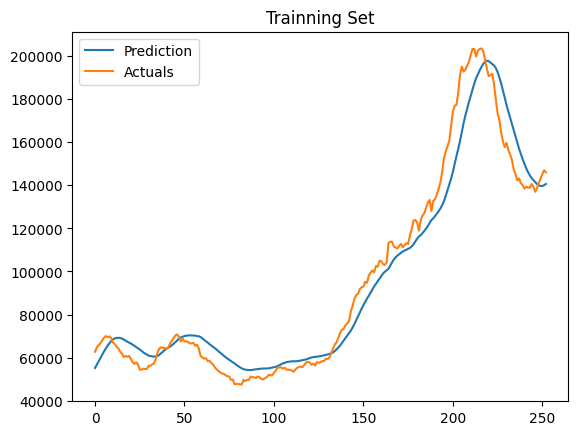

In [88]:
train_predictions = model1.predict(X_train)
train_res = pd.DataFrame(data={'Prediction': list(train_predictions.flatten()), 'Actuals': y_train.flatten()})
train_res = pd.DataFrame(scaler.inverse_transform(train_res), columns = ['Prediction', 'Actuals'])
train_mape = round(np.mean(np.abs((train_res.Actuals - train_res.Prediction)/train_res.Actuals * 100)), 2)
print(f"MAPE: {train_mape}%")
train_res.plot(title="Trainning Set")

2/2 [==============================] - 0s 6ms/step
MAPE: 10.71%


<Axes: title={'center': 'Validation Set'}>

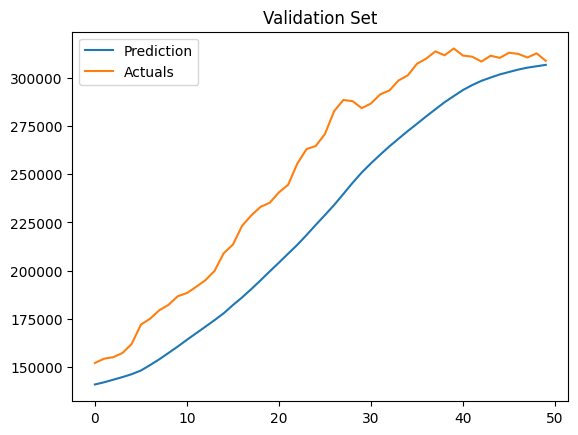

In [92]:
val_predictions = model1.predict(X_val)
val_res = pd.DataFrame(data={'Prediction': list(val_predictions.flatten()), 'Actuals': y_val.flatten()})
val_res = pd.DataFrame(scaler.inverse_transform(val_res), columns = ['Prediction', 'Actuals'])
val_mape = round(np.mean(np.abs((val_res.Actuals - val_res.Prediction)/val_res.Actuals * 100)), 2)
print(f"MAPE: {val_mape}%")
val_res.plot(title="Validation Set")

2/2 [==============================] - 0s 5ms/step
MAPE: 2.24%


<Axes: title={'center': 'Test Set'}>

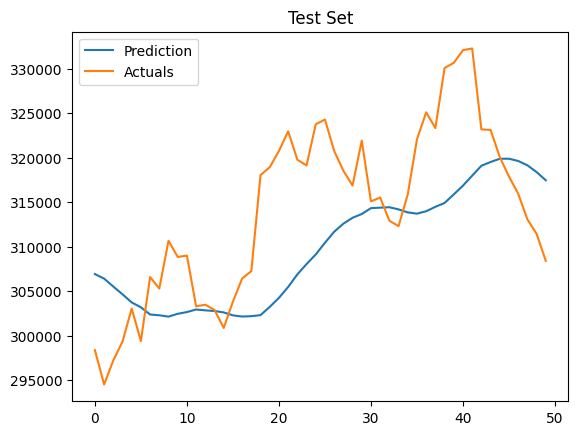

In [93]:
test_predictions = model1.predict(X_test)
test_res = pd.DataFrame(data={'Prediction': list(test_predictions.flatten()), 'Actuals': y_test.flatten()})
test_res = pd.DataFrame(scaler.inverse_transform(test_res), columns = ['Prediction', 'Actuals'])
test_mape = round(np.mean(np.abs((test_res.Actuals - test_res.Prediction)/test_res.Actuals*100)), 2)
print(f"MAPE: {test_mape}%")
test_res.plot(title="Test Set")

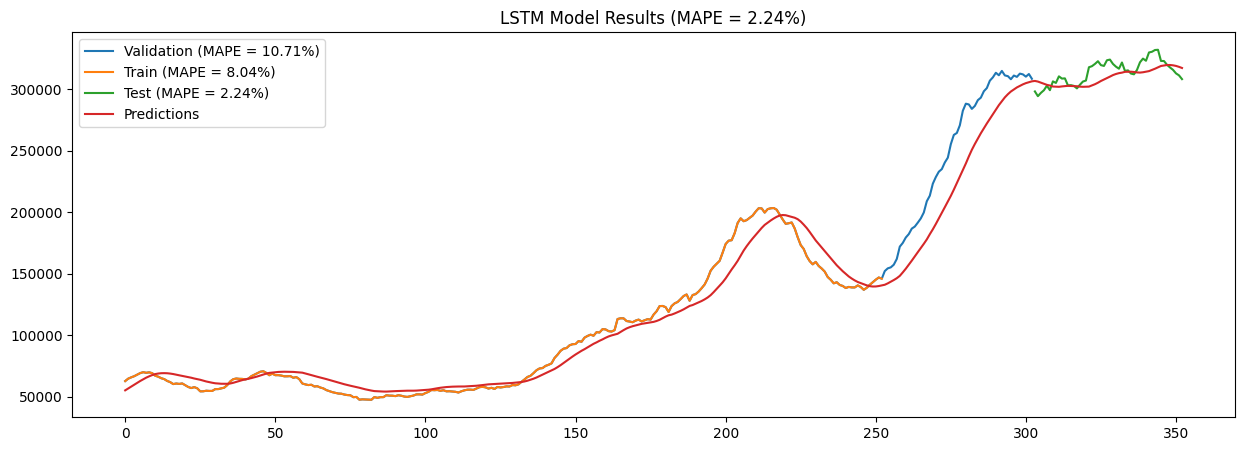

In [94]:

lstm_df = pd.concat([train_res, val_res, test_res]).reset_index(drop=True)
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(lstm_df[:-period_test].index,lstm_df[:-period_test].Actuals, label = f"Validation (MAPE = {val_mape}%)")
ax.plot(lstm_df[:-2*period_test].index,lstm_df[:-2*period_test].Actuals, label = f"Train (MAPE = {train_mape}%)")
ax.plot(lstm_df[-period_test:].index,lstm_df[-period_test:].Actuals, label = f"Test (MAPE = {test_mape}%)")
ax.plot(lstm_df.index, lstm_df.Prediction, label = "Predictions")
plt.legend()
plt.title(f"LSTM Model Results (MAPE = {test_mape}%)")
plt.show()

## Out of Sample Forecast

In [95]:
# Example: Forecasting 100 future time steps
num_forecast_steps = 121

# Create an empty list to store the forecasted values
forecasted_values = []

# Initialize the last known window (X_t) with the last window from the test data
last_known_window = X_test[-1:]

# Perform forecasting for each time step
for i in range(num_forecast_steps):
    # Use the last known window to predict the next time step
    prediction = model1.predict(last_known_window)
    
    # Append the forecasted value to the list
    forecasted_values.append(prediction[0, 0])
    
    # Update the last known window (X_t) with the current prediction and shift the window
    last_known_window = np.append(last_known_window[:, 1:, :], np.expand_dims(prediction, axis=1), axis=1)

forecasted_values = scaler.inverse_transform(pd.DataFrame(forecasted_values))

1/1 [==============================] - 0s 16ms/step


In [46]:
lstm_df.tail()

,Prediction,Actuals
348,320851.266382,317885.419167
349,320364.297410,315963.155833
350,319664.443294,313074.715000
351,318681.752493,311454.179583
352,317582.244045,308407.065833


In [96]:
forecast_df = pd.DataFrame({"Forecast" : forecasted_values.flatten()[1:]
                            #,"Lower_CI" : lower_bound_values.flatten()[1:]
                            #,"Upper_CI" :  upper_bound_values.flatten()[1:]
                           })

forecast_df.index = np.array(range(len(lstm_df), len(lstm_df)+ len(forecast_df)))

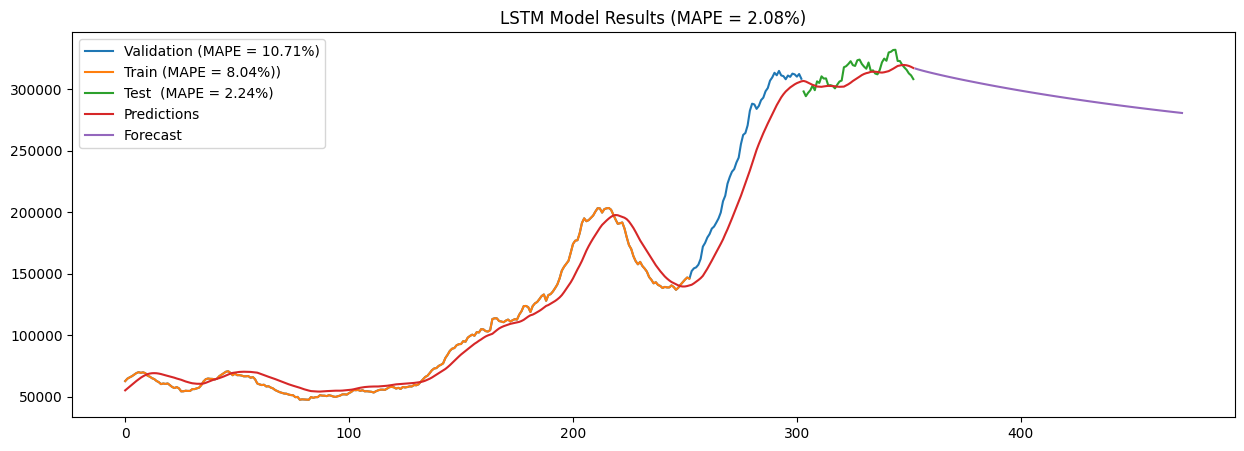

In [98]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(lstm_df[:-period_test].index,lstm_df[:-period_test].Actuals, label = f"Validation (MAPE = {val_mape}%)")
ax.plot(lstm_df[:-2*period_test].index,lstm_df[:-2*period_test].Actuals, label = f"Train (MAPE = {train_mape}%))")
ax.plot(lstm_df[-period_test:].index,lstm_df[-period_test:].Actuals, label = f"Test  (MAPE = {test_mape}%)")
ax.plot(lstm_df.index, lstm_df.Prediction, label = "Predictions")
ax.plot(forecast_df.index, forecast_df.Forecast, label = "Forecast")
plt.legend()
plt.title(f"LSTM Model Results (MAPE = {mape}%)")
plt.show()

## LSTM Function

Epoch 1/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0651 - mean_absolute_percentage_error: 102.8344INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 5s 526ms/step - loss: 0.0592 - mean_absolute_percentage_error: 101.4766 - val_loss: 0.3137 - val_mean_absolute_percentage_error: 99.9702
Epoch 2/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0490 - mean_absolute_percentage_error: 94.8904INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 341ms/step - loss: 0.0531 - mean_absolute_percentage_error: 94.2262 - val_loss: 0.2913 - val_mean_absolute_percentage_error: 96.1121
Epoch 3/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0494 - mean_absolute_percentage_error: 88.8083INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 354ms/step - loss: 0.0494 - mean_absolute_percentage_error: 87.6962 - val_loss: 0.2729 - val_mean_absolute_percentage_error: 92.6495
Epoch 4/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0494 - mean_absolute_percentage_error: 82.2629INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 355ms/step - loss: 0.0455 - mean_absolute_percentage_error: 81.0404 - val_loss: 0.2544 - val_mean_absolute_percentage_error: 89.0263
Epoch 5/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0385 - mean_absolute_percentage_error: 75.0166INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 342ms/step - loss: 0.0415 - mean_absolute_percentage_error: 74.6608 - val_loss: 0.2362 - val_mean_absolute_percentage_error: 85.3354
Epoch 6/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0372 - mean_absolute_percentage_error: 68.4955INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 342ms/step - loss: 0.0378 - mean_absolute_percentage_error: 67.9420 - val_loss: 0.2184 - val_mean_absolute_percentage_error: 81.4333
Epoch 7/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0339 - mean_absolute_percentage_error: 61.1659INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 338ms/step - loss: 0.0342 - mean_absolute_percentage_error: 60.7645 - val_loss: 0.1986 - val_mean_absolute_percentage_error: 77.0869
Epoch 8/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0270 - mean_absolute_percentage_error: 52.8533INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 343ms/step - loss: 0.0303 - mean_absolute_percentage_error: 53.2569 - val_loss: 0.1794 - val_mean_absolute_percentage_error: 72.5242
Epoch 9/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0218 - mean_absolute_percentage_error: 44.6923INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 342ms/step - loss: 0.0264 - mean_absolute_percentage_error: 45.2137 - val_loss: 0.1589 - val_mean_absolute_percentage_error: 67.4458
Epoch 10/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 37.5121INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 482ms/step - loss: 0.0229 - mean_absolute_percentage_error: 37.5861 - val_loss: 0.1359 - val_mean_absolute_percentage_error: 61.2346
Epoch 11/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0218 - mean_absolute_percentage_error: 33.6322INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 339ms/step - loss: 0.0188 - mean_absolute_percentage_error: 33.0068 - val_loss: 0.1120 - val_mean_absolute_percentage_error: 53.8720
Epoch 12/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 31.8304INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 344ms/step - loss: 0.0147 - mean_absolute_percentage_error: 32.4936 - val_loss: 0.0865 - val_mean_absolute_percentage_error: 44.9082
Epoch 13/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0113 - mean_absolute_percentage_error: 37.4006INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 350ms/step - loss: 0.0110 - mean_absolute_percentage_error: 37.0757 - val_loss: 0.0603 - val_mean_absolute_percentage_error: 33.4069
Epoch 14/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0087 - mean_absolute_percentage_error: 43.6153INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 348ms/step - loss: 0.0077 - mean_absolute_percentage_error: 45.3963 - val_loss: 0.0370 - val_mean_absolute_percentage_error: 21.3788
Epoch 15/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0055 - mean_absolute_percentage_error: 54.9186INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 351ms/step - loss: 0.0053 - mean_absolute_percentage_error: 54.9998 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 21.3314
Epoch 16/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0048 - mean_absolute_percentage_error: 64.3096INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 356ms/step - loss: 0.0049 - mean_absolute_percentage_error: 63.6847 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 24.4446
Epoch 17/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0047 - mean_absolute_percentage_error: 62.7093INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 358ms/step - loss: 0.0046 - mean_absolute_percentage_error: 64.3647 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 25.1212
Epoch 18/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0043 - mean_absolute_percentage_error: 62.5695INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 489ms/step - loss: 0.0041 - mean_absolute_percentage_error: 58.7324 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 24.3781
Epoch 19/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0034 - mean_absolute_percentage_error: 51.4883INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 392ms/step - loss: 0.0036 - mean_absolute_percentage_error: 52.7744 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 24.5736
Epoch 20/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0032 - mean_absolute_percentage_error: 48.9830 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 25.7992
Epoch 21/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0029 - mean_absolute_percentage_error: 46.8218 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 28.0436
Epoch 22/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0025 - mean_absolute_percentage_error: 45.4323 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 30.4843
Epoch 23/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0023 - mean_absolute_percentage_error: 43.6749 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 32.4063
Epoch 24/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0021 - 

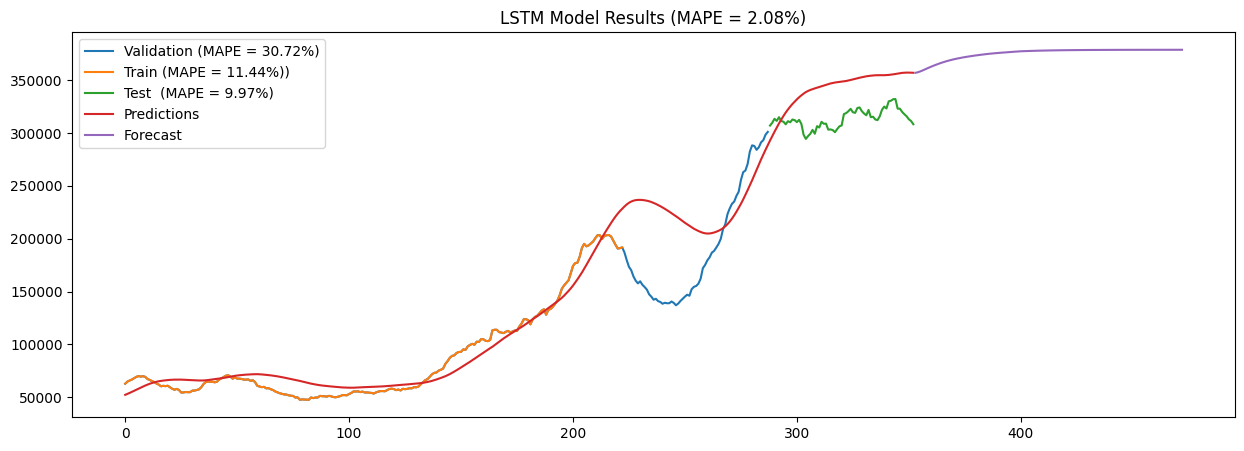

In [113]:

def df_to_X_y(df, window_size = 24):
    df_as_np = df#.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [a for a in df_as_np[i: i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)



window_size = 48 
period_test = 65

scaler = MinMaxScaler()
X, y = df_to_X_y(scaler.fit_transform(df.rolling(window=24).mean().dropna()), window_size= window_size)

X_train, y_train = X[:-2*period_test], y[:-2*period_test]
X_val, y_val = X[-2*period_test:-period_test], y[-2*period_test:-period_test]
X_test, y_test = X[-period_test:], y[-period_test:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

model = Sequential()
model.add(InputLayer((window_size, 1)))
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=MeanAbsolutePercentageError())


model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50
           ,callbacks=[cp]
          )

train_predictions = model.predict(X_train)
train_res = pd.DataFrame(data={'Prediction': list(train_predictions.flatten()), 'Actuals': y_train.flatten()})
train_res = pd.DataFrame(scaler.inverse_transform(train_res), columns = ['Prediction', 'Actuals'])
train_mape = round(np.mean(np.abs((train_res.Actuals - train_res.Prediction)/train_res.Actuals * 100)), 2)
val_predictions = model.predict(X_val)
val_res = pd.DataFrame(data={'Prediction': list(val_predictions.flatten()), 'Actuals': y_val.flatten()})
val_res = pd.DataFrame(scaler.inverse_transform(val_res), columns = ['Prediction', 'Actuals'])
val_mape = round(np.mean(np.abs((val_res.Actuals - val_res.Prediction)/val_res.Actuals * 100)), 2)
test_predictions = model.predict(X_test)
test_res = pd.DataFrame(data={'Prediction': list(test_predictions.flatten()), 'Actuals': y_test.flatten()})
test_res = pd.DataFrame(scaler.inverse_transform(test_res), columns = ['Prediction', 'Actuals'])
test_mape = round(np.mean(np.abs((test_res.Actuals - test_res.Prediction)/test_res.Actuals*100)), 2)
lstm_df = pd.concat([train_res, val_res, test_res]).reset_index(drop=True)

## Out of Sample Forecast

# Example: Forecasting 100 future time steps
num_forecast_steps = 121

# Create an empty list to store the forecasted values
forecasted_values = []

# Initialize the last known window (X_t) with the last window from the test data
last_known_window = X_test[-1:]

# Perform forecasting for each time step
for i in range(num_forecast_steps):
    # Use the last known window to predict the next time step
    prediction = model.predict(last_known_window)
    
    # Append the forecasted value to the list
    forecasted_values.append(prediction[0, 0])
    
    # Update the last known window (X_t) with the current prediction and shift the window
    last_known_window = np.append(last_known_window[:, 1:, :], np.expand_dims(prediction, axis=1), axis=1)


forecasted_values = scaler.inverse_transform(pd.DataFrame(forecasted_values))
forecast_df = pd.DataFrame({"Forecast" : forecasted_values.flatten()[1:]
                            #,"Lower_CI" : lower_bound_values.flatten()[1:]
                            #,"Upper_CI" :  upper_bound_values.flatten()[1:]
                           })

forecast_df.index = np.array(range(len(lstm_df), len(lstm_df)+ len(forecast_df)))



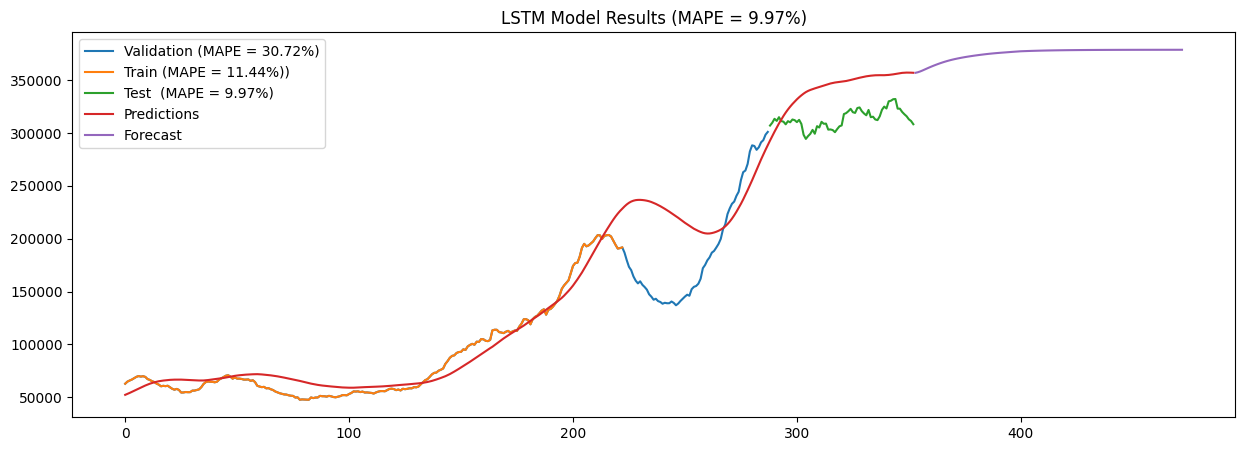

In [114]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(lstm_df[:-period_test].index,lstm_df[:-period_test].Actuals, label = f"Validation (MAPE = {val_mape}%)")
ax.plot(lstm_df[:-2*period_test].index,lstm_df[:-2*period_test].Actuals, label = f"Train (MAPE = {train_mape}%))")
ax.plot(lstm_df[-period_test:].index,lstm_df[-period_test:].Actuals, label = f"Test  (MAPE = {test_mape}%)")
ax.plot(lstm_df.index, lstm_df.Prediction, label = "Predictions")
ax.plot(forecast_df.index, forecast_df.Forecast, label = "Forecast")
plt.legend()
plt.title(f"LSTM Model Results (MAPE = {test_mape}%)")
plt.show()

In [109]:
forecasted_values

[1.5017276,
 1.516413,
 1.5393053,
 1.5661355,
 1.5861474,
 1.6057373,
 1.6252218,
 1.6440182,
 1.661793,
 1.6783544,
 1.6936249,
 1.707584,
 1.7202758,
 1.7317606,
 1.7421135,
 1.751433,
 1.7598075,
 1.7673173,
 1.7740747,
 1.7801269,
 1.7855474,
 1.7904004,
 1.7947266,
 1.7985855,
 1.8020384,
 1.805112,
 1.8078314,
 1.8102341,
 1.8123523,
 1.8142321,
 1.8158628,
 1.8172888,
 1.8185227,
 1.8195881,
 1.8205127,
 1.821314,
 1.8219975,
 1.8225656,
 1.8230462,
 1.8234373,
 1.8237495,
 1.82399,
 1.8241526,
 1.8242614,
 1.82432,
 1.8243353,
 1.8243152,
 1.8242639,
 1.8241881,
 1.824346,
 1.8244728,
 1.8245795,
 1.8246707,
 1.8247478,
 1.8248135,
 1.824869,
 1.8249168,
 1.8249578,
 1.8249933,
 1.825024,
 1.8250502,
 1.8250729,
 1.8250922,
 1.8251085,
 1.8251227,
 1.8251351,
 1.8251451,
 1.825154,
 1.8251612,
 1.8251671,
 1.8251721,
 1.825177,
 1.8251803,
 1.8251834,
 1.825186,
 1.8251884,
 1.8251903,
 1.8251921,
 1.8251934,
 1.825195,
 1.8251964,
 1.8251978,
 1.8251988,
 1.8252002,
 1.825201

In [104]:
window_size = 24 # 2 years

def split_into_sequences(df, window_size = 24):
    n_seq = len(df) - seq_len + 1
    return np.array([df[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test , sequences

x_train, y_train, x_test, y_test, seq = get_train_test_sets(df, seq_len, train_frac=0.9)

NameError: name 'seq_len' is not defined

In [721]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential


# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))

In [723]:
batch_size = 16

model.compile(
    loss='mean_absolute_percentage_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/10
18/18 [==============================] - 9s 115ms/step - loss: 99.9746 - val_loss: 99.9932
Epoch 2/10
18/18 [==============================] - 0s 18ms/step - loss: 99.9734 - val_loss: 99.9928
Epoch 3/10
18/18 [==============================] - 0s 18ms/step - loss: 99.9722 - val_loss: 99.9925
Epoch 4/10
18/18 [==============================] - 0s 17ms/step - loss: 99.9710 - val_loss: 99.9922
Epoch 5/10
18/18 [==============================] - 0s 17ms/step - loss: 99.9698 - val_loss: 99.9919
Epoch 6/10
18/18 [==============================] - 0s 17ms/step - loss: 99.9686 - val_loss: 99.9916
Epoch 7/10
18/18 [==============================] - 0s 18ms/step - loss: 99.9674 - val_loss: 99.9913
Epoch 8/10
18/18 [==============================] - 0s 17ms/step - loss: 99.9662 - val_loss: 99.9910
Epoch 9/10
18/18 [==============================] - 0s 16ms/step - loss: 99.9650 - val_loss: 99.9906
Epoch 10/10
18/18 [==============================] - 0s 16ms/step - loss: 99.9638 - val_lo

2/2 [==============================] - 0s 8ms/step


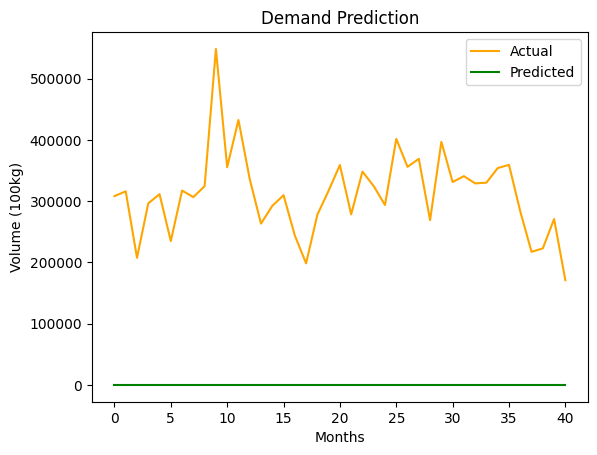

In [726]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
#y_test_orig = scaler.inverse_transform(y_test)
#y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test, label='Actual', color='orange')
plt.plot(y_pred, label='Predicted', color='green')
 
plt.title('Demand Prediction')
plt.xlabel('Months')
plt.ylabel('Volume (100kg)')
plt.legend(loc='best')

plt.show()

In [729]:
len(x_test)

41

# Train / Test Split

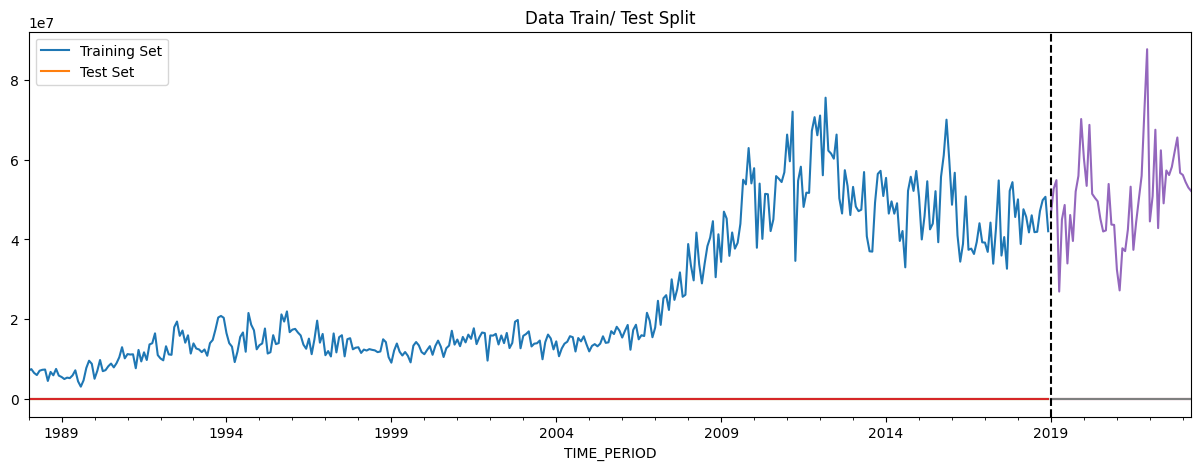

In [31]:
df = df.dropna()
train = df.loc[df.index < '2019-01']
test = df.loc[df.index >= '2019-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2019-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/ Test Split')
plt.show()

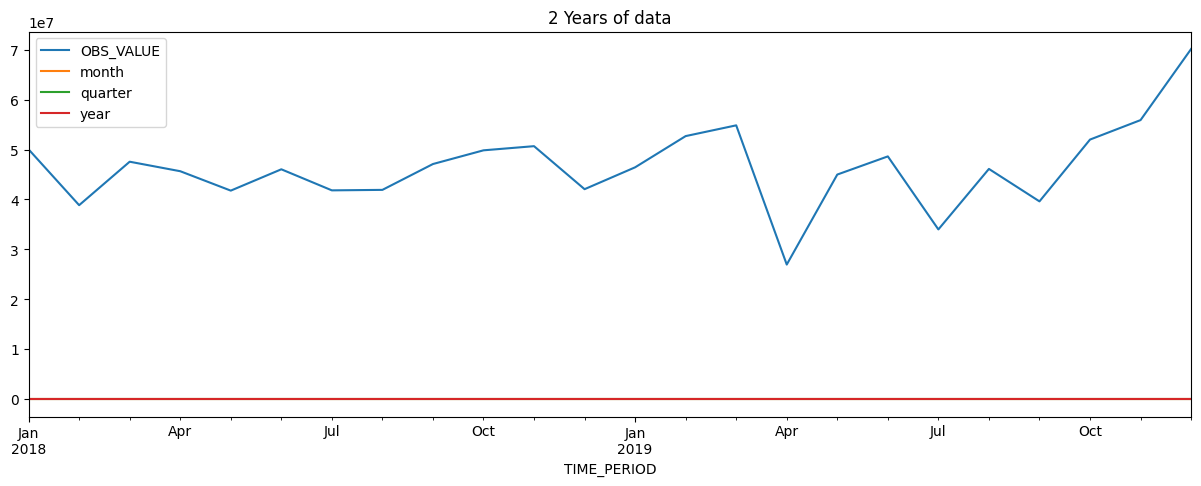

In [32]:
df.loc[(df.index >= '2018-01-01') & (df.index < '2020-01-01')].plot(figsize=(15, 5), title="2 Years of data")
plt.show()

# Feature Creation

In [33]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    
    return df


In [34]:
df = create_features(df)

# Visualize our Feature / Target Relationships

<Axes: xlabel='month', ylabel='OBS_VALUE'>

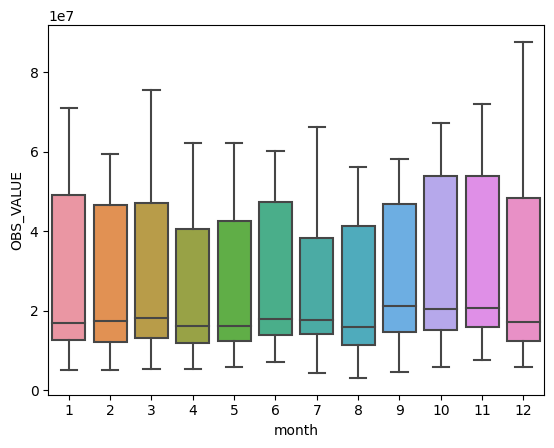

In [35]:
sns.boxplot(data=df, x='month', y='OBS_VALUE')

# Create Model

In [36]:
train = create_features(train)
test = create_features(test)

FEATURES = ['month', 'quarter', 'year']
TARGET = 'OBS_VALUE'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [40]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.001)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:31392207.30715	validation_1-rmse:52029055.75170
[100]	validation_0-rmse:28547455.12165	validation_1-rmse:47580637.50799
[200]	validation_0-rmse:25979018.17428	validation_1-rmse:44051426.80141
[300]	validation_0-rmse:23660409.67298	validation_1-rmse:40875920.37163
[400]	validation_0-rmse:21569219.80156	validation_1-rmse:38015758.87628
[500]	validation_0-rmse:19681970.95234	validation_1-rmse:35372755.76400
[600]	validation_0-rmse:17976583.65334	validation_1-rmse:32912099.44336
[700]	validation_0-rmse:16437842.00266	validation_1-rmse:30735905.25328
[800]	validation_0-rmse:15049724.38166	validation_1-rmse:28800629.17619
[900]	validation_0-rmse:13797483.57424	validation_1-rmse:27067114.80694
[999]	validation_0-rmse:12682799.28772	validation_1-rmse:25503559.08117


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

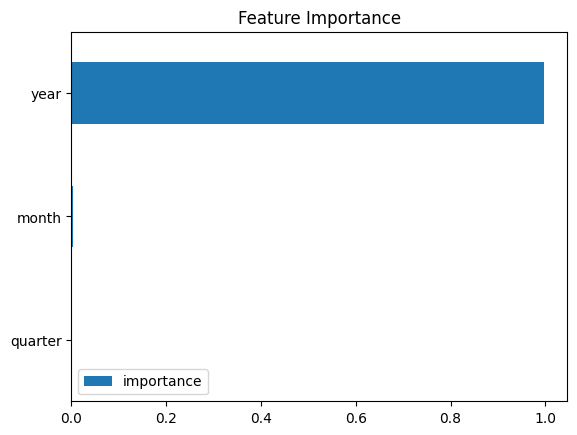

In [43]:
fi= pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [44]:
test['prediction'] = reg.predict(X_test)

In [45]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

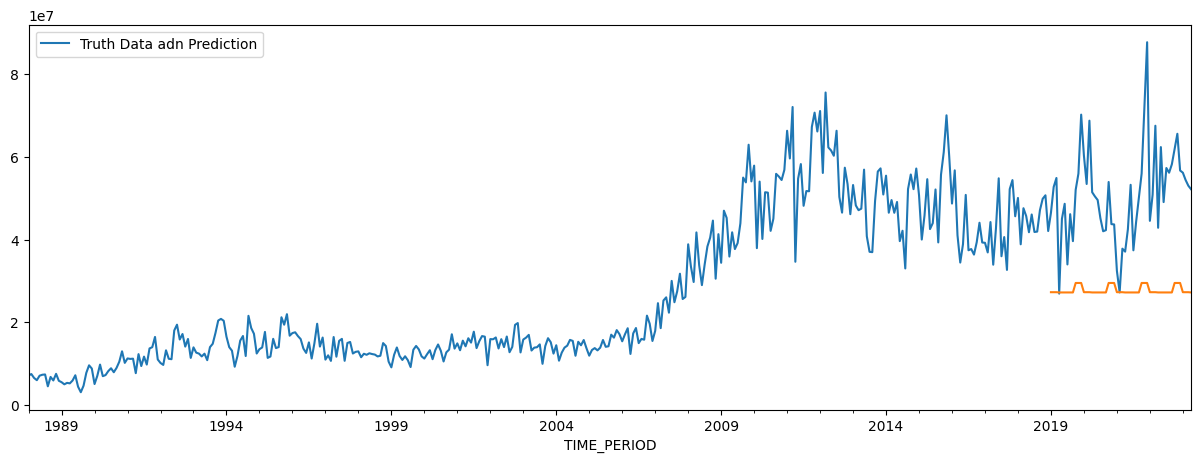

In [48]:
ax = df[['OBS_VALUE']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data adn Prediction'])
plt.show()